<a href="https://colab.research.google.com/github/yasssminee/AiRisk-Money-Laundering-detection/blob/main/AML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# !cp /content/drive/MyDrive/Ibm_dataset_model/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!ls -al /root/.kaggle/
#

ls: cannot access '/root/.kaggle/': No such file or directory


In [ ]:
# # change the file permissions to read/write to the owner only
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml

In [ ]:
# ! unzip ibm-transactions-for-anti-money-laundering-aml.zip

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import re

In [ ]:
Hi_Small_Trans= "/content/drive/MyDrive/Ibm_dataset_model/Dataset/HI-Small_Trans.csv"
df_HI_Small_csv = pd.read_csv(Hi_Small_Trans)

# Transactions info
df_HI_Small_csv.info()
print(df_HI_Small_csv.columns); display(df_HI_Small_csv)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB
Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')


Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1        2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2        2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3        2022/09/01 00:02         12  8000F5030       12  8000F5030   
4        2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                   ...        ...        ...      ...        ...   
5078340  2022/09/10 23:57      54219  8148A6631   256398  8148A8711   
5078341  2022/09/10 23:35         15  8148A8671   256398  8148A8711   
5078342  2022/09/10 23:52     154365  8148A6771   256398  8148A8711   
5078343  2022/09/10 23:46     256398  8148A6311   256398  8148A8711   
5078344  2022/09/10 23:37     154518  8148A6091   256398  8148A8711   

         Amount Received Receiving Currency   Amount Paid Payment Currency  \
0            3697.340000          US Dollar   3697.340000        US Dollar   
1               0.010000          US Dollar      0.010000        US Dollar   
2           14675.570000          US Dollar  14675.570000        US Dollar   
3            2806.970000          US Dollar   2806.970000        US Dollar   
4           36682.970000          US Dollar  36682.970000        US Dollar   
...                  ...                ...           ...              ...   
5078340         0.154978            Bitcoin      0.154978          Bitcoin   
5078341         0.108128            Bitcoin      0.108128          Bitcoin   
5078342         0.004988            Bitcoin      0.004988          Bitcoin   
5078343         0.038417            Bitcoin      0.038417          Bitcoin   
5078344         0.281983            Bitcoin      0.281983          Bitcoin   

        Payment Format  Is Laundering  
0         Reinvestment              0  
1               Cheque              0  
2         Reinvestment              0  
3         Reinvestment              0  
4         Reinvestment              0  
...                ...            ...  
5078340        Bitcoin              0  
5078341        Bitcoin              0  
5078342        Bitcoin              0  
5078343        Bitcoin              0  
5078344        Bitcoin              0  

[5078345 rows x 11 columns]

1- Data Preprocessing

In [ ]:
# checking the number of missing values in each column
df_HI_Small_csv.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [ ]:
# distribution of legit transactions & fraudulent transactions
df_HI_Small_csv['Is Laundering'].value_counts()

0    5073168
1       5177
Name: Is Laundering, dtype: int64

Replace two columns "Receiving Currency" & "Payment Currency" to one column named "Conversion"

In [ ]:
df_HI_Small_csv.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [ ]:
# Currencies available
payment_currencies=pd.DataFrame()
payment_currencies = pd.concat([df_HI_Small_csv['Receiving Currency'], df_HI_Small_csv['Payment Currency']]).unique()
print(len(payment_currencies))
for c in (payment_currencies):
    print(c)

15
US Dollar
Bitcoin
Euro
Australian Dollar
Yuan
Rupee
Mexican Peso
Yen
UK Pound
Ruble
Canadian Dollar
Swiss Franc
Brazil Real
Saudi Riyal
Shekel


In [ ]:
possible_conversions=[]
for i in range (0,len(payment_currencies)):
    for j in range (0,len(payment_currencies)):
        possible_conversions.append(payment_currencies[i]+"_"+payment_currencies[j])
print(len(possible_conversions))
for c in possible_conversions:
    print(c)
#print(possible_conversions)

225
US Dollar_US Dollar
US Dollar_Bitcoin
US Dollar_Euro
US Dollar_Australian Dollar
US Dollar_Yuan
US Dollar_Rupee
US Dollar_Mexican Peso
US Dollar_Yen
US Dollar_UK Pound
US Dollar_Ruble
US Dollar_Canadian Dollar
US Dollar_Swiss Franc
US Dollar_Brazil Real
US Dollar_Saudi Riyal
US Dollar_Shekel
Bitcoin_US Dollar
Bitcoin_Bitcoin
Bitcoin_Euro
Bitcoin_Australian Dollar
Bitcoin_Yuan
Bitcoin_Rupee
Bitcoin_Mexican Peso
Bitcoin_Yen
Bitcoin_UK Pound
Bitcoin_Ruble
Bitcoin_Canadian Dollar
Bitcoin_Swiss Franc
Bitcoin_Brazil Real
Bitcoin_Saudi Riyal
Bitcoin_Shekel
Euro_US Dollar
Euro_Bitcoin
Euro_Euro
Euro_Australian Dollar
Euro_Yuan
Euro_Rupee
Euro_Mexican Peso
Euro_Yen
Euro_UK Pound
Euro_Ruble
Euro_Canadian Dollar
Euro_Swiss Franc
Euro_Brazil Real
Euro_Saudi Riyal
Euro_Shekel
Australian Dollar_US Dollar
Australian Dollar_Bitcoin
Australian Dollar_Euro
Australian Dollar_Australian Dollar
Australian Dollar_Yuan
Australian Dollar_Rupee
Australian Dollar_Mexican Peso
Australian Dollar_Yen
Australia

In [ ]:
# Replace payment currency and recieving currency with one column
df_HI_Small_csv ['Conversion']=df_HI_Small_csv['Receiving Currency']+'_'+df_HI_Small_csv['Payment Currency']
df_HI_Small_csv.drop(['Receiving Currency','Payment Currency'], axis=1, inplace=True)
display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1        2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2        2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3        2022/09/01 00:02         12  8000F5030       12  8000F5030   
4        2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                   ...        ...        ...      ...        ...   
5078340  2022/09/10 23:57      54219  8148A6631   256398  8148A8711   
5078341  2022/09/10 23:35         15  8148A8671   256398  8148A8711   
5078342  2022/09/10 23:52     154365  8148A6771   256398  8148A8711   
5078343  2022/09/10 23:46     256398  8148A6311   256398  8148A8711   
5078344  2022/09/10 23:37     154518  8148A6091   256398  8148A8711   

         Amount Received   Amount Paid Payment Format  Is Laundering  \
0            3697.340000   3697.340000   Reinvestment              0   
1               0.010000      0.010000         Cheque              0   
2           14675.570000  14675.570000   Reinvestment              0   
3            2806.970000   2806.970000   Reinvestment              0   
4           36682.970000  36682.970000   Reinvestment              0   
...                  ...           ...            ...            ...   
5078340         0.154978      0.154978        Bitcoin              0   
5078341         0.108128      0.108128        Bitcoin              0   
5078342         0.004988      0.004988        Bitcoin              0   
5078343         0.038417      0.038417        Bitcoin              0   
5078344         0.281983      0.281983        Bitcoin              0   

                  Conversion  
0        US Dollar_US Dollar  
1        US Dollar_US Dollar  
2        US Dollar_US Dollar  
3        US Dollar_US Dollar  
4        US Dollar_US Dollar  
...                      ...  
5078340      Bitcoin_Bitcoin  
5078341      Bitcoin_Bitcoin  
5078342      Bitcoin_Bitcoin  
5078343      Bitcoin_Bitcoin  
5078344      Bitcoin_Bitcoin  

[5078345 rows x 10 columns]

In [ ]:
# Scaling
# Converting all payments to US Dollar and replace Amount Received & Amount Paid with one column
df_HI_Small_csv['Amount in US Dollar']=0
# Rates taken in 15/07/2023
def convert_to_Us_Dollar(amount,currency):
    conversion_rate={
        'US Dollar': 1.0,
        'Euro': 1.12,
        'Australian Dollar': 0.68,
        'Yuan': 0.14,
        'Rupee': 0.012,
        'Yen': 0.0072 ,
        'Mexican Peso': 0.060,
        'UK Pound': 1.31,
        'Ruble': 0.011,
        'Canadian Dollar': 0.76,
        'Swiss Franc': 1.16,
        'Brazil Real': 0.21,
        'Saudi Riyal': 0.27,
        'Bitcoin': 30344.30,
        'Shekel': 0.28
    }
    return amount*conversion_rate[currency]

for index, row in df_HI_Small_csv.iterrows():
    conversion = row['Conversion']
    amount_received = row['Amount Received']
    amount_paid = row['Amount Paid']
    parts=conversion.split('_')
    if 'Us Dollar' in conversion:
        if 'Us Dollar' in parts[0]:
            df_HI_Small_csv.at[index,'Amount in US Dollar']=amount_received
        else:
            df_HI_Small_csv.at[index,'Amount in US Dollar']=amount_paid
    else:
        df_HI_Small_csv.at[index,'Amount in US Dollar']=convert_to_Us_Dollar(amount_received,parts[0])

display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1        2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2        2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3        2022/09/01 00:02         12  8000F5030       12  8000F5030   
4        2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                   ...        ...        ...      ...        ...   
5078340  2022/09/10 23:57      54219  8148A6631   256398  8148A8711   
5078341  2022/09/10 23:35         15  8148A8671   256398  8148A8711   
5078342  2022/09/10 23:52     154365  8148A6771   256398  8148A8711   
5078343  2022/09/10 23:46     256398  8148A6311   256398  8148A8711   
5078344  2022/09/10 23:37     154518  8148A6091   256398  8148A8711   

         Amount Received   Amount Paid Payment Format  Is Laundering  \
0            3697.340000   3697.340000   Reinvestment              0   
1               0.010000      0.010000         Cheque              0   
2           14675.570000  14675.570000   Reinvestment              0   
3            2806.970000   2806.970000   Reinvestment              0   
4           36682.970000  36682.970000   Reinvestment              0   
...                  ...           ...            ...            ...   
5078340         0.154978      0.154978        Bitcoin              0   
5078341         0.108128      0.108128        Bitcoin              0   
5078342         0.004988      0.004988        Bitcoin              0   
5078343         0.038417      0.038417        Bitcoin              0   
5078344         0.281983      0.281983        Bitcoin              0   

                  Conversion  Amount in US Dollar  
0        US Dollar_US Dollar          3697.340000  
1        US Dollar_US Dollar             0.010000  
2        US Dollar_US Dollar         14675.570000  
3        US Dollar_US Dollar          2806.970000  
4        US Dollar_US Dollar         36682.970000  
...                      ...                  ...  
5078340      Bitcoin_Bitcoin          4702.698925  
5078341      Bitcoin_Bitcoin          3281.068470  
5078342      Bitcoin_Bitcoin           151.357368  
5078343      Bitcoin_Bitcoin          1165.736973  
5078344      Bitcoin_Bitcoin          8556.576747  

[5078345 rows x 11 columns]

In [ ]:
df_HI_Small_csv.drop(['Amount Received','Amount Paid'], axis=1, inplace=True)
display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1        2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2        2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3        2022/09/01 00:02         12  8000F5030       12  8000F5030   
4        2022/09/01 00:06         10  8000F5200       10  8000F5200   
...                   ...        ...        ...      ...        ...   
5078340  2022/09/10 23:57      54219  8148A6631   256398  8148A8711   
5078341  2022/09/10 23:35         15  8148A8671   256398  8148A8711   
5078342  2022/09/10 23:52     154365  8148A6771   256398  8148A8711   
5078343  2022/09/10 23:46     256398  8148A6311   256398  8148A8711   
5078344  2022/09/10 23:37     154518  8148A6091   256398  8148A8711   

        Payment Format  Is Laundering           Conversion  \
0         Reinvestment              0  US Dollar_US Dollar   
1               Cheque              0  US Dollar_US Dollar   
2         Reinvestment              0  US Dollar_US Dollar   
3         Reinvestment              0  US Dollar_US Dollar   
4         Reinvestment              0  US Dollar_US Dollar   
...                ...            ...                  ...   
5078340        Bitcoin              0      Bitcoin_Bitcoin   
5078341        Bitcoin              0      Bitcoin_Bitcoin   
5078342        Bitcoin              0      Bitcoin_Bitcoin   
5078343        Bitcoin              0      Bitcoin_Bitcoin   
5078344        Bitcoin              0      Bitcoin_Bitcoin   

         Amount in US Dollar  
0                3697.340000  
1                   0.010000  
2               14675.570000  
3                2806.970000  
4               36682.970000  
...                      ...  
5078340          4702.698925  
5078341          3281.068470  
5078342           151.357368  
5078343          1165.736973  
5078344          8556.576747  

[5078345 rows x 9 columns]

In [ ]:
df_HI_Small_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Timestamp            object 
 1   From Bank            int64  
 2   Account              object 
 3   To Bank              int64  
 4   Account.1            object 
 5   Payment Format       object 
 6   Is Laundering        int64  
 7   Conversion           object 
 8   Amount in US Dollar  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 348.7+ MB


Convert 'Timestamp' column to Datetime Format


In [ ]:
df_HI_Small_csv['Timestamp']=pd.to_datetime(df_HI_Small_csv['Timestamp'])
display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0       2022-09-01 00:20:00         10  8000EBD30       10  8000EBD30   
1       2022-09-01 00:20:00       3208  8000F4580        1  8000F5340   
2       2022-09-01 00:00:00       3209  8000F4670     3209  8000F4670   
3       2022-09-01 00:02:00         12  8000F5030       12  8000F5030   
4       2022-09-01 00:06:00         10  8000F5200       10  8000F5200   
...                     ...        ...        ...      ...        ...   
5078340 2022-09-10 23:57:00      54219  8148A6631   256398  8148A8711   
5078341 2022-09-10 23:35:00         15  8148A8671   256398  8148A8711   
5078342 2022-09-10 23:52:00     154365  8148A6771   256398  8148A8711   
5078343 2022-09-10 23:46:00     256398  8148A6311   256398  8148A8711   
5078344 2022-09-10 23:37:00     154518  8148A6091   256398  8148A8711   

        Payment Format  Is Laundering           Conversion  \
0         Reinvestment              0  US Dollar_US Dollar   
1               Cheque              0  US Dollar_US Dollar   
2         Reinvestment              0  US Dollar_US Dollar   
3         Reinvestment              0  US Dollar_US Dollar   
4         Reinvestment              0  US Dollar_US Dollar   
...                ...            ...                  ...   
5078340        Bitcoin              0      Bitcoin_Bitcoin   
5078341        Bitcoin              0      Bitcoin_Bitcoin   
5078342        Bitcoin              0      Bitcoin_Bitcoin   
5078343        Bitcoin              0      Bitcoin_Bitcoin   
5078344        Bitcoin              0      Bitcoin_Bitcoin   

         Amount in US Dollar  
0                3697.340000  
1                   0.010000  
2               14675.570000  
3                2806.970000  
4               36682.970000  
...                      ...  
5078340          4702.698925  
5078341          3281.068470  
5078342           151.357368  
5078343          1165.736973  
5078344          8556.576747  

[5078345 rows x 9 columns]

In [ ]:
df_HI_Small_csv.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Payment Format', 'Is Laundering', 'Conversion', 'Amount in US Dollar'],
      dtype='object')

Apply Encoding or Embeddings on different categorical features --> 'Payment Format', 'Account', 'Account.1',  'Conversion'

Conversion :

Target Encoding --> Bayesian Target Encoding

In [ ]:
# Bayesian Target Encoding  on 'Conversion' column
# Negative_counts,Positive_counts=df_HI_Small_csv['Is Laundering'].value_counts()
# num_rows = df_HI_Small_csv.shape[0]
laundering_transactions=df_HI_Small_csv
Ranked_apperance_dict = {}
for i in range(len(possible_conversions)):
    conversion_type = possible_conversions[i]
    count = laundering_transactions[laundering_transactions['Conversion'] == conversion_type].shape[0]
    Ranked_apperance_dict[conversion_type]=count
Ranked_apperance_dict = dict(sorted(Ranked_apperance_dict.items(), key=lambda x: x[1], reverse=True))
print(Ranked_apperance_dict)

{'US Dollar_US Dollar': 1856392, 'Euro_Euro': 1153708, 'Swiss Franc_Swiss Franc': 234429, 'Yuan_Yuan': 203522, 'Shekel_Shekel': 192066, 'Rupee_Rupee': 189006, 'UK Pound_UK Pound': 177939, 'Ruble_Ruble': 154852, 'Yen_Yen': 153603, 'Bitcoin_Bitcoin': 146013, 'Canadian Dollar_Canadian Dollar': 139065, 'Australian Dollar_Australian Dollar': 136478, 'Mexican Peso_Mexican Peso': 109656, 'Saudi Riyal_Saudi Riyal': 88891, 'Brazil Real_Brazil Real': 70555, 'Euro_US Dollar': 15838, 'US Dollar_Euro': 11060, 'US Dollar_Yuan': 6675, 'Yuan_US Dollar': 2547, 'Swiss Franc_US Dollar': 2507, 'UK Pound_US Dollar': 2489, 'Rupee_US Dollar': 2310, 'Shekel_US Dollar': 2204, 'Yen_US Dollar': 2027, 'Ruble_US Dollar': 1934, 'US Dollar_UK Pound': 1772, 'Canadian Dollar_US Dollar': 1531, 'Bitcoin_US Dollar': 1496, 'Australian Dollar_US Dollar': 1391, 'Euro_Yuan': 1230, 'US Dollar_Yen': 1045, 'Mexican Peso_US Dollar': 911, 'Saudi Riyal_US Dollar': 838, 'US Dollar_Rupee': 803, 'Brazil Real_US Dollar': 757, 'US Doll

In [ ]:
# Finding most frequent money laundering currency conversions in flagged dataset (df_HI_Small_csv['Is Laundering']==1)
laundering_transactions=df_HI_Small_csv[df_HI_Small_csv['Is Laundering']==1]
Ranked_conversions_dict = {}
for i in range(len(possible_conversions)):
    conversion_type = possible_conversions[i]
    count = laundering_transactions[laundering_transactions['Conversion'] == conversion_type].shape[0]
    Ranked_conversions_dict[conversion_type]=count

Ranked_conversions_dict = dict(sorted(Ranked_conversions_dict.items(), key=lambda x: x[1], reverse=True))
# Display the sorted ranked conversions
#print(Ranked_conversions_dict)

# Bayesian target encoding
def Baysesian_target_encoding(c):  # Weighted_mean= (n*option_mean + m*Overall_mean) / n+m
    count_c= Ranked_apperance_dict[c] # Number of rows where c appears
    alpha= 2 # Hyper parameter (user defined)
    mean_c= Ranked_conversions_dict[c] # valeur moyenn de c signalé
    total_transactions= df_HI_Small_csv.shape[0]
    total_flagged= df_HI_Small_csv[df_HI_Small_csv['Is Laundering']==1].shape[0]
    global_mean= total_flagged/total_transactions # valeur moyenne de tout les transaction signalé 'In Laundering'=1
    return ((count_c*mean_c + alpha*global_mean) / alpha+ count_c)

Encoded_values={}
for i in possible_conversions:
    Encoded_values[i]=Baysesian_target_encoding(i)

def Min_Max(value,min_value,max_value):
    return ( (value - min_value) / (max_value - min_value) )


min_value= next(iter(Encoded_values.values()))
max_value= next(iter(Encoded_values.values()))

# min value
for value in Encoded_values.values():
    if value < min_value:
        min_value = value
# max value
for value in Encoded_values.values():
    if value > max_value:
        max_value = value

print(min_value)
print(max_value)
# Normalise the values
for i in Encoded_values:
    Encoded_values[i]=Min_Max(Encoded_values[i],min_value,max_value)

Encoded_values= dict(sorted(Encoded_values.items(), key=lambda x: x[1], reverse=True))


print("Encoded values: ")
for i in Encoded_values:
    print(i,Encoded_values[i])



def find_duplicates_and_counts(my_dict):
    value_counts = {}
    for value in my_dict.values():
        value_counts[value] = value_counts.get(value, 0) + 1
    duplicates = {key: value for key, value in value_counts.items() if value > 1}
    duplicates = dict(sorted(duplicates.items(), key=lambda x: x[1], reverse=True))
    return duplicates

print("Duplicated sorted values:" )
print(find_duplicates_and_counts(Encoded_values))


0.0010194266045335635
1776567144.0010195
Encoded values: 
US Dollar_US Dollar 1.0
Euro_Euro 0.4461398482330595
Swiss Franc_Swiss Franc 0.012865726790678506
Yuan_Yuan 0.010653999801766007
Saudi Riyal_Saudi Riyal 0.00940662899031977
Rupee_Rupee 0.008989813334068954
Yen_Yen 0.006787154395330864
UK Pound_UK Pound 0.006710645888202917
Ruble_Ruble 0.005883543459250196
Shekel_Shekel 0.005243371201285709
Canadian Dollar_Canadian Dollar 0.005088028916063304
Australian Dollar_Australian Dollar 0.0049549666781409304
Mexican Peso_Mexican Peso 0.0029010060314387984
Bitcoin_Bitcoin 0.0023834601547713863
Brazil Real_Brazil Real 0.0011715698486428835
Euro_US Dollar 8.914945913240417e-06
US Dollar_Euro 6.225489443139223e-06
US Dollar_Yuan 3.7572461150953267e-06
Yuan_US Dollar 1.4336637985240145e-06
Swiss Franc_US Dollar 1.4111484659990987e-06
UK Pound_US Dollar 1.4010165663628867e-06
Rupee_US Dollar 1.3002604533138885e-06
Shekel_US Dollar 1.2405948221228614e-06
Yen_US Dollar 1.1409644757001089e-06
Rubl

In [ ]:
# with open('Encoded_values.json', 'w') as file:
#     json.dump(Encoded_values, file)

In [ ]:
# Map each value in Conversion with its encoded value
df_HI_Small_csv['Conversion'] = df_HI_Small_csv['Conversion'].replace(Encoded_values)
display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0       2022-09-01 00:20:00         10  8000EBD30       10  8000EBD30   
1       2022-09-01 00:20:00       3208  8000F4580        1  8000F5340   
2       2022-09-01 00:00:00       3209  8000F4670     3209  8000F4670   
3       2022-09-01 00:02:00         12  8000F5030       12  8000F5030   
4       2022-09-01 00:06:00         10  8000F5200       10  8000F5200   
...                     ...        ...        ...      ...        ...   
5078340 2022-09-10 23:57:00      54219  8148A6631   256398  8148A8711   
5078341 2022-09-10 23:35:00         15  8148A8671   256398  8148A8711   
5078342 2022-09-10 23:52:00     154365  8148A6771   256398  8148A8711   
5078343 2022-09-10 23:46:00     256398  8148A6311   256398  8148A8711   
5078344 2022-09-10 23:37:00     154518  8148A6091   256398  8148A8711   

        Payment Format  Is Laundering  Conversion  Amount in US Dollar  
0         Reinvestment              0    1.000000          3697.340000  
1               Cheque              0    1.000000             0.010000  
2         Reinvestment              0    1.000000         14675.570000  
3         Reinvestment              0    1.000000          2806.970000  
4         Reinvestment              0    1.000000         36682.970000  
...                ...            ...         ...                  ...  
5078340        Bitcoin              0    0.002383          4702.698925  
5078341        Bitcoin              0    0.002383          3281.068470  
5078342        Bitcoin              0    0.002383           151.357368  
5078343        Bitcoin              0    0.002383          1165.736973  
5078344        Bitcoin              0    0.002383          8556.576747  

[5078345 rows x 9 columns]

Payment Format:

Frequency Encoding

In [ ]:
# Display payement format
payment_format = df_HI_Small_csv["Payment Format"].unique()
num_payment_format = len(payment_format)
print("Number of Payment Format:", num_payment_format)
print("Payment Formats:")
for pay_format in payment_format:
    print(pay_format)


Ranked_apperance_format_dict = {}
for i in range(len(payment_format)):
    format = payment_format[i]
    count = df_HI_Small_csv[df_HI_Small_csv['Payment Format'] == format].shape[0]
    Ranked_apperance_format_dict[format]=count
Ranked_apperance_format_dict = dict(sorted(Ranked_apperance_format_dict.items(), key=lambda x: x[1], reverse=True))
print(Ranked_apperance_format_dict)
average_dict={}
num_rows = df_HI_Small_csv.shape[0]

for i in Ranked_apperance_format_dict:
    average_dict[i]=Ranked_apperance_format_dict[i] / num_rows
average_dict= {k: round(v, 4)  for k, v in average_dict.items()}
print(average_dict)

Number of Payment Format: 7
Payment Formats:
Reinvestment
Cheque
Credit Card
ACH
Cash
Wire
Bitcoin
{'Cheque': 1864331, 'Credit Card': 1323324, 'ACH': 600797, 'Cash': 490891, 'Reinvestment': 481056, 'Wire': 171855, 'Bitcoin': 146091}
{'Cheque': 0.3671, 'Credit Card': 0.2606, 'ACH': 0.1183, 'Cash': 0.0967, 'Reinvestment': 0.0947, 'Wire': 0.0338, 'Bitcoin': 0.0288}


In [ ]:
df_HI_Small_csv['Payment Format'] = df_HI_Small_csv['Payment Format'].replace(average_dict)
display(df_HI_Small_csv)

Timestamp  From Bank    Account  To Bank  Account.1  \
0       2022-09-01 00:20:00         10  8000EBD30       10  8000EBD30   
1       2022-09-01 00:20:00       3208  8000F4580        1  8000F5340   
2       2022-09-01 00:00:00       3209  8000F4670     3209  8000F4670   
3       2022-09-01 00:02:00         12  8000F5030       12  8000F5030   
4       2022-09-01 00:06:00         10  8000F5200       10  8000F5200   
...                     ...        ...        ...      ...        ...   
5078340 2022-09-10 23:57:00      54219  8148A6631   256398  8148A8711   
5078341 2022-09-10 23:35:00         15  8148A8671   256398  8148A8711   
5078342 2022-09-10 23:52:00     154365  8148A6771   256398  8148A8711   
5078343 2022-09-10 23:46:00     256398  8148A6311   256398  8148A8711   
5078344 2022-09-10 23:37:00     154518  8148A6091   256398  8148A8711   

         Payment Format  Is Laundering  Conversion  Amount in US Dollar  
0                0.0947              0    1.000000          3697.340000  
1                0.3671              0    1.000000             0.010000  
2                0.0947              0    1.000000         14675.570000  
3                0.0947              0    1.000000          2806.970000  
4                0.0947              0    1.000000         36682.970000  
...                 ...            ...         ...                  ...  
5078340          0.0288              0    0.002383          4702.698925  
5078341          0.0288              0    0.002383          3281.068470  
5078342          0.0288              0    0.002383           151.357368  
5078343          0.0288              0    0.002383          1165.736973  
5078344          0.0288              0    0.002383          8556.576747  

[5078345 rows x 9 columns]

In [ ]:
# with open('average_dict.json', 'w') as file:
#     json.dump(average_dict, file)

Account

Convert them from Hexadecimal to int

In [ ]:
df_HI_Small_csv['Account'] = df_HI_Small_csv['Account'].apply(lambda x: int(x, 16))
df_HI_Small_csv['Account.1'] = df_HI_Small_csv['Account.1'].apply(lambda x: int(x, 16))
display(df_HI_Small_csv)

Timestamp  From Bank      Account  To Bank    Account.1  \
0       2022-09-01 00:20:00         10  34360704304       10  34360704304   
1       2022-09-01 00:20:00       3208  34360739200        1  34360742720   
2       2022-09-01 00:00:00       3209  34360739440     3209  34360739440   
3       2022-09-01 00:02:00         12  34360741936       12  34360741936   
4       2022-09-01 00:06:00         10  34360742400       10  34360742400   
...                     ...        ...          ...      ...          ...   
5078340 2022-09-10 23:57:00      54219  34704352817   256398  34704361233   
5078341 2022-09-10 23:35:00         15  34704361073   256398  34704361233   
5078342 2022-09-10 23:52:00     154365  34704353137   256398  34704361233   
5078343 2022-09-10 23:46:00     256398  34704352017   256398  34704361233   
5078344 2022-09-10 23:37:00     154518  34704351377   256398  34704361233   

         Payment Format  Is Laundering  Conversion  Amount in US Dollar  
0                0.0947              0    1.000000          3697.340000  
1                0.3671              0    1.000000             0.010000  
2                0.0947              0    1.000000         14675.570000  
3                0.0947              0    1.000000          2806.970000  
4                0.0947              0    1.000000         36682.970000  
...                 ...            ...         ...                  ...  
5078340          0.0288              0    0.002383          4702.698925  
5078341          0.0288              0    0.002383          3281.068470  
5078342          0.0288              0    0.002383           151.357368  
5078343          0.0288              0    0.002383          1165.736973  
5078344          0.0288              0    0.002383          8556.576747  

[5078345 rows x 9 columns]

In [ ]:
df_HI_Small_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Timestamp            datetime64[ns]
 1   From Bank            int64         
 2   Account              int64         
 3   To Bank              int64         
 4   Account.1            int64         
 5   Payment Format       float64       
 6   Is Laundering        int64         
 7   Conversion           float64       
 8   Amount in US Dollar  float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 348.7 MB


1st Solution : Create Vector Database

In [ ]:
# from vector_database import *

In [ ]:
class Vector_Database:

    def __init__(self):
        self.vectors=[]

    def create_feature_vector(self, df):
        for _, row in df.iterrows():
            vector = np.array(row)  # Convert the row to a NumPy array (vector)
            self.vectors.append(vector)

    def show(self):
        for vector in self.vectors:
            print(vector)

In [ ]:
vector_db= Vector_Database()
vector_db.create_feature_vector(df_HI_Small_csv)

In [ ]:
for i, vector in enumerate(vector_db.vectors):
    if i < 5:
        print(vector)
    else:
        break

[Timestamp('2022-09-01 00:20:00') 10 34360704304 10 34360704304 0.0947 0
 1.0 3697.34]
[Timestamp('2022-09-01 00:20:00') 3208 34360739200 1 34360742720 0.3671 0
 1.0 0.01]
[Timestamp('2022-09-01 00:00:00') 3209 34360739440 3209 34360739440 0.0947
 0 1.0 14675.57]
[Timestamp('2022-09-01 00:02:00') 12 34360741936 12 34360741936 0.0947 0
 1.0 2806.97]
[Timestamp('2022-09-01 00:06:00') 10 34360742400 10 34360742400 0.0947 0
 1.0 36682.97]


Couldn't find a way to extract patterns from a scenario using transactions as vectors

2nd Solution: Graph

In [ ]:
# # Create a directed graph presenting all the transactions in the database
# # networkx Library
# from Scenario_Extraction import *
# import re

In [ ]:
# import pandas as pd
# import json
# import re
# import networkx as nx
# from vector_database import *

# with open('Encoded_values.json', 'r') as file:
#     Encoded_values= json.load(file)
# with open('average_dict.json', 'r') as file:
#     average_dict= json.load(file)

def create_graph_from_vectors(my_graph,vectors):
     #my_graph= nx.MultiDiGraph()
     for vector in vectors:
          # Chack if nodes exist and create them
          bank_from = vector[1]
          account_from=vector[2]
          label_from=f"{vector[1]}_{vector[2]}"
          # node_label_mapping(label_from)
          if not my_graph.has_node(label_from):
               my_graph.add_node(label_from,account=account_from,bank=bank_from)
          bank_to=vector[3]
          account_to=vector[4]
          label_to=f"{vector[3]}_{vector[4]}"
          # node_label_mapping(label_to)
          if not my_graph.has_node(label_to):
               my_graph.add_node(label_to,account=account_to,bank=bank_to)
          # Create edge between "from" and "to" accounts
          my_graph.add_edge(label_from,label_to,
                            time=vector[0],
                            amount=vector[8],
                            pay_format=vector[5],
                            pay_conversion=vector[7])


def Extract_Scenarios(file_path):
    with open(file_path, 'r') as file:
        scenarios=[]
        current_scenario=[]
        current_scenario_type=None
        for line in file:

            if line.startswith('BEGIN LAUNDERING ATTEMPT'):
                #print('Begiiin')
                #print(line)
                prefix = "BEGIN LAUNDERING ATTEMPT - "
                current_scenario_type = line[len(prefix):].split(':')[0].strip()
            if line.startswith('END LAUNDERING ATTEMPT'):
                #print('End line ')
                scenarios.append((current_scenario_type, current_scenario))
                current_scenario=[]
                current_scenario_type=[]
            else:
                if re.match(r'^\d{4}/\d{2}/\d{2} \d{2}:\d{2}', line):
                    #print('Transaction')
                    transation=line.strip().split(',')

                    Timestamp=pd.to_datetime(transation[0]) # convert to timestamp format

                    From_Bank=int(transation[1]) # int value
                    #From_Account=transation[2].apply(lambda x: int(x, 16)) # Convert to int
                    From_Account=int(transation[2], 16)
                    To_Bank=int(transation[3])
                    #To_Account=transation[4].apply(lambda x: int(x, 16)) # Convert to int
                    To_Account=int(transation[4], 16)

                    Pay_Format=Format_type(transation[9])
                    Pay_Conversion,Amount=Conversion_Amount(float(transation[5]),transation[6],float(transation[7]),transation[8])
                    transaction_line=[Timestamp,From_Bank,From_Account,To_Bank,To_Account,Pay_Format,Pay_Conversion,Amount]
                    current_scenario.append(transaction_line)
                    # transaction : timestamp / From_bank / From_Account / To_Bank / To_Account / Pay_Format / Pay_Conversion / Amount
    return(scenarios)

def Display_Scenarios(scenarios):
    for scenario_type, scenario in scenarios:
        print("Scenario Type:", scenario_type)
        for transaction in scenario:
            print("Transaction:", transaction)
        print("\n")

def Conversion_Amount(Amount_Recieved, Recieving_Currency, Amount_Paid, Payment_Currency):
    # with open('Encoded_values.json','r') as file:
    #     Encoded_values=json.load(file)
    Conversion=Recieving_Currency+'_'+Payment_Currency
    parts=Conversion.split('_')
    if 'Us Dollar' in Conversion:
        if 'Us Dollar' in parts[0]:
            Amount=Amount_Recieved
        else:
            Amount=Amount_Paid
    else:
        Amount=convert_to_Us_Dollar(Amount_Recieved,parts[0])
    return Encoded_values[Conversion] , Amount



def Format_type(Pay_format):
    # with open('average_dict.json','r') as file:
    #     average_dict=json.load(file)
    return average_dict[Pay_format]


def create_graph_scenarios(Scenarios):
    graph_dict = {}
    # iterate through all the scenarios that exist
    for scenario_name,scenario in Scenarios:
        # create a graph and iterate through the transactions in the scenarios
        my_graph= nx.MultiDiGraph()
        transactions=scenario
        # For each transaction we create the edge and both nodes
        for transaction in transactions:
            bank_from= transaction[1]
            account_from= transaction[2]
            label_from=f"{transaction[1]}_{transaction[2]}"
            if not my_graph.has_node(label_from):
                my_graph.add_node(label_from,account=account_from,bank=bank_from)
            bank_to=transaction[3]
            account_to=transaction[4]
            label_to=f"{transaction[3]}_{transaction[4]}"
            if not my_graph.has_node(label_to):
                my_graph.add_node(label_to,account=account_to, bank=bank_to)
            # Create edge between "from" and "to" accounts
            # transaction : timestamp / From_bank / From_Account / To_Bank / To_Account / Pay_Format / Pay_Conversion / Amount
            my_graph.add_edge(label_from,label_to,time=transaction[0],amount=transaction[7],pay_format=transaction[5],pay_conversion=transaction[6] )

        if scenario_name in graph_dict:

            graph_dict[scenario_name].append(my_graph)  # Add the graph to the existing list
        else:
            graph_dict[scenario_name] = [my_graph]  # Create a new list with the graph
    return graph_dict

In [ ]:
graph1=nx.MultiDiGraph()
create_graph_from_vectors(graph1,vector_db.vectors)

In [ ]:
print(len(graph1.edges()))

5078345


Create a dataset of GraphScenarios

1- Extract Scenarios from txt file and save them in vectors db

In [ ]:
Scenarios=Extract_Scenarios("/content/drive/MyDrive/Ibm_dataset_model/Dataset/HI-Small_Patterns.txt")
Display_Scenarios(Scenarios)

Scenario Type: FAN-OUT
Transaction: [Timestamp('2022-09-01 00:06:00'), 21174, 34367305360, 12, 34360916368, 0.1183, 0.4461398482330595, 3190.8352000000004]
Transaction: [Timestamp('2022-09-01 04:33:00'), 21174, 34367305360, 20, 34361886128, 0.1183, 0.4461398482330595, 9666.048]
Transaction: [Timestamp('2022-09-01 09:14:00'), 21174, 34367305360, 20, 34360174048, 0.1183, 0.010653999801766007, 4989.948600000001]
Transaction: [Timestamp('2022-09-01 09:56:00'), 21174, 34367305360, 220, 34367757168, 0.1183, 1.0, 5738987.96]
Transaction: [Timestamp('2022-09-01 11:28:00'), 21174, 34367305360, 1244, 34369421520, 0.1183, 1.0, 7254.53]
Transaction: [Timestamp('2022-09-01 13:13:00'), 21174, 34367305360, 513, 34367660544, 0.1183, 1.0, 6990.87]
Transaction: [Timestamp('2022-09-01 14:11:00'), 21174, 34367305360, 20, 34366470544, 0.1183, 0.4461398482330595, 14041.350400000001]
Transaction: [Timestamp('2022-09-02 15:40:00'), 21174, 34367305360, 410, 34362671888, 0.1183, 0.4461398482330595, 3933.2384000

Create a dectionnary containing all scenarios in graph format

In [ ]:
# key are scenario_name and value is a list of graphs
scenarios_dict=create_graph_scenarios(Scenarios)
# print("All nodes in the graph:", my_graph.nodes())
print(scenarios_dict)

{'FAN-OUT': [<networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da66bf0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da64820>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da662f0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da64100>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3c70>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b1b40>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3e50>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2c20>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b27d0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2800>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b25c0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2050>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3430>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b

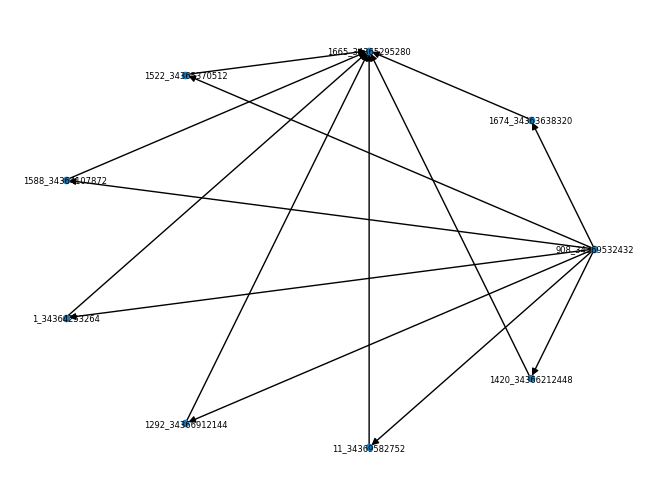

In [ ]:
my_graph=scenarios_dict['SCATTER-GATHER'][1]
pos = nx.circular_layout(my_graph)  # You can use different layout algorithms, like 'spring_layout', 'circular_layout', 'random_layout', etc.
nx.draw(my_graph, pos, with_labels=True, node_size=20, font_size=6, font_color='black')
# Show the plot
plt.show()

Extract Fimilar scenarios

In [ ]:
print('number of scenarios : ',len(scenarios_dict))
for s in scenarios_dict:
    print(s,len(scenarios_dict[s]))

number of scenarios :  8
FAN-OUT 48
CYCLE 54
GATHER-SCATTER 51
STACK 43
RANDOM 41
BIPARTITE 49
FAN-IN 40
SCATTER-GATHER 44


Graph classification model for our dataset

Create adjacency matrix for each graph

In [ ]:
# Create Adjacency matrix for each scenario
def Create_Adjacency_Matrix(my_graph):
    node_list = list(my_graph.nodes())
    node_index = {node: idx for idx, node in enumerate(node_list)}
    num_nodes=my_graph.number_of_nodes()
    adj_matrix=np.zeros((num_nodes,num_nodes), dtype=int)

    for edge in my_graph.edges():
        node1, node2= edge
        idx1, idx2 = node_index[node1], node_index[node2]
        adj_matrix[idx1][idx2] = 1

    return adj_matrix

def create_adjacency_matrices(graph_dict):
    adjacency_matrices = {}
    for label, graphs in graph_dict.items():
        adjacency_matrices[label] = []
        for graph in graphs:
            adj_matrix = Create_Adjacency_Matrix(graph)
            adjacency_matrices[label].append(adj_matrix)
    return adjacency_matrices

In [ ]:
# for label, graphs in scenarios_dict.items():
#         print(f"Label: {label}")
#         for idx, graph in enumerate(graphs):
#             adj_matrix = Create_Adjacency_Matrix(graph)
#             print(f"Graph {idx+1} - Adjacency Matrix:")
#             print(adj_matrix)

adj_matrix_scenarios=create_adjacency_matrices(scenarios_dict)
display(scenarios_dict['GATHER-SCATTER'][1])

GNN model

Mini-batching of graphs

PyTorch Geometric automatically takes care of batching multiple graphs into a single giant graph

In [ ]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=e23b24dff00b606cf717ea348c8dd7e73c0f4c030917cd8411b5d32d59c74de1
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
# We have to create data objects representing the graphs labeled
import torch
from torch_geometric.data import Data

def class_name_to_label(class_name):   # For classification
    class_mapping = {
        'CYCLE': 0,
        'FAN-OUT': 1,
        'FAN-IN': 2,
        'STACK': 3,
        'GATHER-SCATTER': 4,
        'SCATTER-GATHER': 5,
        'RANDOM': 6,
        'BIPARTITE': 7}
    return class_mapping[class_name]


def label_to_index(vectors):        # Map Node Labels to numeric values for Data Pyg format
  label_to_index={}
  counter=0
  for vector in vectors:
          # Chack if nodes exist and create them
          bank_from = vector[1]
          account_from=vector[2]
          label_from=f"{vector[1]}_{vector[2]}"
          if label_from not in label_to_index:
            label_to_index[label_from]=counter
            counter+=1

          bank_to=vector[3]
          account_to=vector[4]
          label_to=f"{vector[3]}_{vector[4]}"
          if label_to not in label_to_index:
            label_to_index[label_to]=counter
            counter+=1
  return label_to_index

In [ ]:
# Data_objects = []
index_dect= label_to_index(vector_db.vectors)

# for class_label, graph_list in scenarios_dict.items():
#     for graph in graph_list:
#         data = graph_to_Data(graph, class_label)
#         Data_objects.append(data)

Same steps for Scenarios
create a dataset and data loaders using PyTorch Geometric (Data objects)

In [ ]:
train_set={}
test_set={}
for scenario_name , graph_list in scenarios_dict.items():
    train_set[scenario_name]=graph_list[:28]
    test_set[scenario_name]=graph_list[28:]

In [ ]:
from torch_geometric.data import DataLoader

def convert_to_data(graph_obj, class_label):  # Convert the NetworkX MultiDiGraph to PyTorch Geometric Data format
    node_features = []
    edge_indices = []
    edge_attributes = []

    index_counter= 0
    index_dectionnary= {}

    class_label= class_name_to_label(class_label)

    for node_label, node_data in graph_obj.nodes(data=True):
      bank_id = node_data['bank']
      account_id = node_data['account']
      label = f"{bank_id}_{account_id}"
      # node_features.append([])

    for source, target, edge_data in graph_obj.edges(data=True):
      timestamp = edge_data['time']
      timestamp_numeric = timestamp.timestamp()  # Convert to UNIX timestamp (numeric)
      amount = edge_data['amount']
      pay_format = edge_data['pay_format']
      pay_conversion = edge_data['pay_conversion']

      # source= index_dect[source]
      # target= index_dect[target]

      if source not in index_dectionnary:
        index_dectionnary[source]= index_counter
        source= index_counter
        index_counter+=1
      else:
        source= index_dectionnary[source]

      if target not in index_dectionnary:
        index_dectionnary[target]= index_counter
        target= index_counter
        index_counter+=1
      else:
        target= index_dectionnary[target]

      # considering source and target values as node features
      if source not in node_features:
        node_features.append([source])
      if target not in node_features:
        node_features.append([target])

      edge_indices.append([source, target])
      edge_attributes.append([timestamp_numeric, amount, pay_format, pay_conversion])


    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()  # should have a shepe of 2xN
    edge_attr = torch.tensor(edge_attributes, dtype=torch.float)
    y = torch.tensor(class_label , dtype=torch.long)

    data = Data(x=x, edge_index=edge_index,edge_attr=edge_attr, y=y)
    # print(edge_index.shape)
    # print(index_dectionnary)
    return data


train_dataset = []
test_dataset = []

# Convert graphs to PyTorch Geometric Data format and add them to the datasets
for class_label, train_graphs in train_set.items():
    for graph in train_graphs:
        data = convert_to_data(graph, class_label)
        train_dataset.append(data)

for class_label, test_graphs in test_set.items():
    for graph in test_graphs:
        data = convert_to_data(graph, class_label)
        test_dataset.append(data)

batch_size= 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 224
Number of test graphs: 146


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GNN model



In [ ]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)

        self.hidden_layer = Linear(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, num_classes)  # takes the learned features from the GNN layers and maps them to class scores

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index) # adding a 4th GConLayer

        x = global_mean_pool(x, batch)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.lin(x)
        return x

In [ ]:
# input_size= 2   # Dimension of your node features
input_size = 1  # Use the number of edge attributes

hidden_channels= 260
num_classes= 8
model = GNN(input_size, hidden_channels, num_classes)
print(model)

GNN(
  (conv1): GCNConv(1, 260)
  (conv2): GCNConv(260, 260)
  (conv3): GCNConv(260, 260)
  (conv4): GCNConv(260, 260)
  (hidden_layer): Linear(in_features=260, out_features=260, bias=True)
  (lin): Linear(in_features=260, out_features=8, bias=True)
)


In [ ]:
# Define your optimizer and loss function
import torch.optim as optim
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
# optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.4)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
num_epochs = 400

def train():
    model.train()
    for data in train_loader:
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, num_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.1473, Test Acc: 0.1096
Epoch: 002, Train Acc: 0.1920, Test Acc: 0.1918
Epoch: 003, Train Acc: 0.2589, Test Acc: 0.2877
Epoch: 004, Train Acc: 0.3527, Test Acc: 0.3425
Epoch: 005, Train Acc: 0.3616, Test Acc: 0.3151
Epoch: 006, Train Acc: 0.4107, Test Acc: 0.3082
Epoch: 007, Train Acc: 0.4509, Test Acc: 0.4178
Epoch: 008, Train Acc: 0.4286, Test Acc: 0.3562
Epoch: 009, Train Acc: 0.4420, Test Acc: 0.4521
Epoch: 010, Train Acc: 0.5134, Test Acc: 0.4589
Epoch: 011, Train Acc: 0.5714, Test Acc: 0.5000
Epoch: 012, Train Acc: 0.4420, Test Acc: 0.4726
Epoch: 013, Train Acc: 0.5625, Test Acc: 0.5753
Epoch: 014, Train Acc: 0.5714, Test Acc: 0.5822
Epoch: 015, Train Acc: 0.5536, Test Acc: 0.5274
Epoch: 016, Train Acc: 0.6607, Test Acc: 0.6370
Epoch: 017, Train Acc: 0.6920, Test Acc: 0.6301
Epoch: 018, Train Acc: 0.6473, Test Acc: 0.5479
Epoch: 019, Train Acc: 0.6429, Test Acc: 0.6370
Epoch: 020, Train Acc: 0.6741, Test Acc: 0.5822
Epoch: 021, Train Acc: 0.6964, Test Acc:

In [ ]:
# Evaluation
# ~ 0.7 for hidden_channels=265 and learning_rate==0.005 + batch_size=16
# ~ 0.8 for 3 conv layers


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(out, dim=1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7945


2nd test dataset


In [ ]:
Scenarios2=Extract_Scenarios("/content/drive/MyDrive/Ibm_dataset_model/Dataset/HI-Medium_Patterns.txt")
scenarios_dict2=create_graph_scenarios(Scenarios2)
print(scenarios_dict)

test_dataset2= []

for class_label, test_graphs in scenarios_dict2.items():
    for graph in test_graphs:
        data = convert_to_data(graph, class_label)
        test_dataset2.append(data)

batch_size= 64
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)
print(f'Number of test graphs 2: {len(test_dataset2)}')

# Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader2:
        out = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(out, dim=1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

accuracy = correct / total
print(f"2nd Test Accuracy: {accuracy:.4f}")


{'FAN-OUT': [<networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da66bf0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da64820>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da662f0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b319da64100>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3c70>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b1b40>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3e50>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2c20>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b27d0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2800>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b25c0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b2050>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b3430>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b32191b

3rd test dataset

+ Confidence score: the likelihood that the output of the model is correct


In [ ]:
def get_confidence_score(logits):
    probabilities = F.softmax(logits, dim=1)
    confidence_score = torch.max(probabilities, dim=1).values
    return confidence_score

Scenarios3= Extract_Scenarios("/content/drive/MyDrive/Ibm_dataset_model/Dataset/HI-Large_Patterns.txt")
scenarios_dict3= create_graph_scenarios(Scenarios3)
print(scenarios_dict3)

test_dataset3= []

for class_label, test_graphs in scenarios_dict3.items():
    for graph in test_graphs:
        data = convert_to_data(graph, class_label)
        test_dataset3.append(data)

batch_size= 64
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)
print(f'Number of test graphs3 : {len(test_dataset3)}')

# Model
model.eval()
correct = 0
total = 0

correct_indices = []  # To store the indices of correct predictions
confidence_scores = []  # To store the confidence scores of correct predictions


with torch.no_grad():
    for data in test_loader3:
        out = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(out, dim=1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()
        # Confidence score
        is_correct = (predicted == data.y)
        correct_indices.extend([index * batch_size + i for i, correct in enumerate(is_correct) if correct])
        correct_confidence_scores = get_confidence_score(out[is_correct])
        confidence_scores.extend(correct_confidence_scores.tolist())



accuracy = correct / total
print(f"3rd Test Accuracy: {accuracy:.4f}")

print("Indices of Correct Predictions:")
print(correct_indices)

print("Confidence Scores of Correct Predictions:")
print(confidence_scores)

{'STACK': [<networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078bf40>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078bb20>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078b940>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078b8e0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078b460>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff078b580>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0788a00>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0772a40>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0772740>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0772a70>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0773bb0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff0773670>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff07727a0>, <networkx.classes.multidigraph.MultiDiGraph object at 0x7b2ff34a1f

In [ ]:
count_under_0_9 = sum(1 for score in confidence_scores if score < 0.9)
print(f"Number of Confidence Scores Under 0.9: {count_under_0_9}")

min_conf_score= min(confidence_scores)
print('Minimum score of correct classifications')
print(min_conf_score)

correct_classified_with_low_conf= ( count_under_0_9/len(test_dataset3) ) * 100
print(f"Percentage of correct classified score under 0.9: {correct_classified_with_low_conf:.4f} %")

Number of Confidence Scores Under 0.9: 1960
Minimum score of correct classifications
0.4084385931491852
Percentage of correct classified score under 0.9: 11.9026 %


Final accuracy : 0.8

*texte en italique*~ 10% of correct classified scenarios showing a confidence score under 0.9

Scenario Extraction



In [ ]:
# df = pd.read_csv(Hi_Small_Trans)
accounts= []
bank_account_columns= ['From Bank', 'Account', 'To Bank', 'Account.1']
bank_account_df = df_HI_Small_csv[bank_account_columns]

for index, row in bank_account_df.iterrows():
    from_bank_id = row['From Bank']
    from_account_id = row['Account']
    to_bank_id = row['To Bank']
    to_account_id = row['Account.1']

    accounts.append((from_bank_id, from_account_id))
    accounts.append((to_bank_id, to_account_id))

unique_accounts = list(set(accounts))

In [ ]:
print("Number of accounts:", len(unique_accounts))
import random
random_samples = random.sample(unique_accounts, 200)

Number of accounts: 515088


In [ ]:
# Remove subgraphs extracted from the initial big graph
def Remove_subgraphs_extracted(Subgraphs):
    nodes_to_remove=[]
    for subgraph in Subgraphs:
        nodes_to_remove.extend(subgraph.nodes())

    graph1.remove_nodes_from(nodes_to_remove)

In [ ]:
Predected_Scenarios = {'SCATTER-GATHER' : [],
                      'GATHER-SCATTER': [],
                       'FAN-OUT' : [],
                       'FAN-IN': [],
                       'CYCLE': [],
                       'RANDOM' :[],
                       'STACK' : [],
                       'BIPARTITE': []
                       }

In [ ]:
def subgraph_creation(filtered_df):
    my_graph= nx.MultiDiGraph()
    for index, transaction in filtered_df.iterrows():
                bank_from= transaction[1]
                account_from= transaction[2]
                label_from=f"{transaction[1]}_{transaction[2]}"
                if not my_graph.has_node(label_from):
                    my_graph.add_node(label_from,account=account_from,bank=bank_from)
                bank_to=transaction[3]
                account_to=transaction[4]
                label_to=f"{transaction[3]}_{transaction[4]}"
                if not my_graph.has_node(label_to):
                    my_graph.add_node(label_to,account=account_to, bank=bank_to)
                my_graph.add_edge(label_from,label_to,time=transaction[0],amount=transaction[7],pay_format=transaction[5],pay_conversion=transaction[6] )
    pos = nx.circular_layout(my_graph)  # Positions of nodes
    nx.draw(my_graph, pos, with_labels=True, node_size=500, font_size=10, node_color='lightblue')
    plt.title(f"Node {nodeA} and Its Neighbors")
    plt.show()
    return(my_graph)

Scatter-Gather Extraction

In [ ]:
def scatter_gather_scenario(nodeA):
  list_of_SGscenarios=[]

  if graph1.has_node(nodeA):
    neighbors = list(graph1.neighbors(nodeA))
    if nodeA in neighbors:
        neighbors.remove(nodeA)

    matrix_of_neighbors = []
    for neighbor in neighbors:
      row= list(graph1.successors(neighbor))
      matrix_of_neighbors.append(row)
    redundent_elements={}
    seen_elements=[]

    for row in matrix_of_neighbors:
        for target_element in row:
            if target_element not in seen_elements:
                seen_elements.append(target_element)
                counter=0
                for test_row in matrix_of_neighbors:
                    if target_element in test_row:
                        counter += 1
                # print(f"{target_element} : {counter}")
                if counter > 1:
                    redundent_elements[target_element] = counter

    sorted_dict = dict(sorted(redundent_elements.items(), key=lambda item: item[1], reverse=True))
    # print(sorted_dict)
    # Subgraph scenarios extraction
    # while
    for node, value in sorted_dict.items():
      if value > 1:
        sc_ga_sc= nx.MultiDiGraph()
        nodeB, nb_of_edges = node,value
        list_neighbors=[]
        for row_index, row in enumerate(matrix_of_neighbors):
          if nodeB in row:
              list_neighbors.append(row_index)

        list_intermidiate=[]
        for i in list_neighbors:
          list_intermidiate.append(neighbors[i])
        # print("List of Neighbor Indices:", list_neighbors)
        # print("List of Intermediate Nodes:", list_intermediate)
        list_intermidiate.append(nodeA)
        list_intermidiate.append(nodeB)
        sc_ga_sc = graph1.subgraph(list_intermidiate).copy() # create a copy of extracted graph so i can modify it
        self_loop_edges = [(u, v) for u, v in sc_ga_sc.edges() if u == v]# Remove additional edges
        sc_ga_sc.remove_edges_from(self_loop_edges)
        list_of_SGscenarios.append(sc_ga_sc)


  return list_of_SGscenarios


def Extract_SG_Scenarios():
  SG_scenarios=[]
  accounts_to_remove = []
  for account in random_samples:
      nodeA= f"{account[0]}_{account[1]}"
      list_scenarios_from_node= scatter_gather_scenario(nodeA)
      if len(list_scenarios_from_node):
          accounts_to_remove.append(account)
      SG_scenarios.extend(list_scenarios_from_node)

  for account in accounts_to_remove:
    random_samples.remove(account)

  return SG_scenarios

SG_scenarios= Extract_SG_Scenarios()
Predected_Scenarios['SCATTER-GATHER'].extend(SG_scenarios)
Remove_subgraphs_extracted(SG_scenarios)

Exemple of Extraction


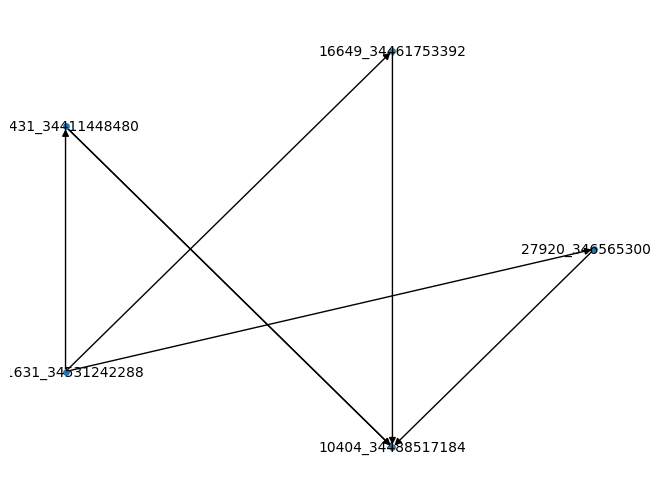

In [ ]:
# Scenario Type: SCATTER-GATHER

nodeA= '111631_34531242288'
list_of_SGscenarios= scatter_gather_scenario(nodeA)

my_graph=list_of_SGscenarios[0]
pos = nx.circular_layout(my_graph)  # You can use different layout algorithms, like 'spring_layout', 'circular_layout', 'random_layout', etc.
nx.draw(my_graph, pos, with_labels=True, node_size=15, font_size=10, font_color='black')
plt.show()
Predected_Scenarios['SCATTER-GATHER'].append(my_graph)


Cycle and Random scenario

In [ ]:
# # random.seed(50)

# # new_df = df_HI_Small_csv.sample(n=1000, random_state=random.seed())
# new_df = df_HI_Small_csv.reset_index(drop=True)


# # Cycle scenarios
# for index , row in new_df.iterrows():
#         rows_to_remove = []
#         first_row_in_sc = new_df.iloc[index]

#         index_before= index
#         row_before= first_row_in_sc

#         current_row_index= index+1
#         cycle_sc= pd.DataFrame(columns= new_df.columns)
#         cycle_sc.append(first_row_in_sc)

#         cycle_flag=0
#         random_flag=0

#         while (current_row_index < (len(new_df)-1)) & (len(cycle_sc) < 13) & (cycle_flag==0) :
#             # print(f" Length of the scenario {len(cycle_sc)}")
#             current_row = new_df.iloc[current_row_index]
#             row_before=new_df.iloc[index_before]
#             # print(f" length of sce  {len(cycle_sc)}")
#             if (current_row['From Bank'] == row_before['To Bank']) & (current_row['Account']==row_before['Account.1']):
#                 # cycle_sc.append(current_row, ignore_index=True)
#                 cycle_sc = pd.concat([cycle_sc, first_row_in_sc], ignore_index=True)
#                 if (current_row['To Bank'] == first_row_in_sc['From Bank']).all() & (current_row['Account.1'] == first_row_in_sc['Account']).all():
#                     cycle_flag= 1
#                     break
#             if ( 2 <  len(cycle_sc) <= 5 )  :
#                 random_flag= 1
#                 break

#             index_before= current_row_index
#             current_row_index+= 1

#         # display(cycle_sc)

#         if (cycle_flag==1):
#             rows_to_remove.append(cycle_sc)
#             cycle_graph= subgraph_creation(cycle_sc)
#             print(' Cycle scenario')
#             Predected_Scenarios['CYCLE'].append(cycle_graph)

#             pos = nx.circular_layout(cycle_graph)  # Positions of nodes
#             nx.draw(cycle_graph, pos, with_labels=True, node_size=500, font_size=10, node_color='lightblue')
#             plt.title(" Cycle  detected ")
#             plt.show()



# # Remove Cycle scenario
# for scenario_df in rows_to_remove:
#     new_df = new_df[~new_df.isin(scenario_df.to_dict(orient='list')).all(axis=1)]


# # Random scenarios
# for index , row in new_df.iterrows():

#         first_row_in_sc = new_df.iloc[index]
#         index_before= index
#         row_before= first_row_in_sc

#         current_row_index= index+1
#         random_sc= pd.DataFrame(columns= new_df.columns)
#         random_sc.append(first_row_in_sc)

#         while (current_row_index < (len(new_df)-1)) & (len(random_sc) < 13) & (random_flag==0):
#             # print(f" Length of the scenario {len(cycle_sc)}")
#             current_row = new_df.iloc[current_row_index]
#             row_before=new_df.iloc[index_before]
#             index_before= current_row_index
#             current_row_index+= 1

#         if ( 1 < len(random_sc) < 13):
#             random_graph= subgraph_creation(random_sc)
#             print(' Random scenario')
#             rows_to_remove.append(random_sc)
#             Predected_Scenarios['RANDOM'].append(random_graph)

#             pos = nx.circular_layout(random_graph)  # Positions of nodes
#             nx.draw(random_graph, pos, with_labels=True, node_size=500, font_size=10, node_color='lightblue')
#             plt.title(" Random  detected ")
#             plt.show()





Gather_Scatter / Fan_in / Fan_out Extraction

In [ ]:
df_HI_Small_csv= df_HI_Small_csv.sort_values(by= 'Timestamp', ascending=True)
df_HI_Small_csv= df_HI_Small_csv.drop('Is Laundering', axis=1)
display(df_HI_Small_csv)


Timestamp  From Bank      Account  To Bank    Account.1  \
316720  2022-09-01 00:00:00        121  34665904560      121  34665904560   
261688  2022-09-01 00:00:00      25170  34516694976    25170  34516694976   
261696  2022-09-01 00:00:00      25665  34521732272    24779  34512346016   
126680  2022-09-01 00:00:00      32317  34373690512    12004  34373691216   
126564  2022-09-01 00:00:00       1024  34372901328     1024  34372901328   
...                     ...        ...          ...      ...          ...   
4962230 2022-09-18 10:02:00       9371  34430652336    16163  34409514608   
4962231 2022-09-18 11:18:00       9371  34430652336     9371  34430652336   
4962232 2022-09-18 11:18:00       9371  34430652336    13858  34516313776   
4962233 2022-09-18 12:58:00       9371  34430652336     1124  34400012256   
4962234 2022-09-18 16:18:00       9371  34430652336     4503  34514010416   

         Payment Format  Conversion  Amount in US Dollar  
316720           0.0947    0.009407              12.8628  
261688           0.0947    0.005088            2977.2392  
261696           0.2606    0.005088              74.0924  
126680           0.0338    0.446140           15611.7360  
126564           0.0947    0.446140              11.6144  
...                 ...         ...                  ...  
4962230          0.1183    1.000000            3749.1400  
4962231          0.1183    0.000009            1999.5024  
4962232          0.1183    0.446140            1999.5024  
4962233          0.1183    1.000000            2154.5400  
4962234          0.1183    1.000000            5448.5500  

[5078345 rows x 8 columns]

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
251305 2022-09-01 00:11:00     323001  34506022656   220504  34506033616   

        Payment Format  Conversion  Amount in US Dollar  
251305          0.1183    0.006711            1291.2932

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2256310 2022-09-04 20:26:00      28248  34533508272   228101  34533541152   

         Payment Format  Conversion  Amount in US Dollar  
2256310          0.1183    0.004955            3445.2812

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1136987 2022-09-02 00:03:00          4  34461939696   217096  34474508944   
4439715 2022-09-09 07:55:00     217096  34474508944   217824  34474508864   

         Payment Format  Conversion  Amount in US Dollar  
1136987          0.2606    0.005884             36.63198  
4439715          0.1183    0.005884           3453.22923

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 1136987
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  1
 Check Fan_in or Fan_out scenario
Random scenario


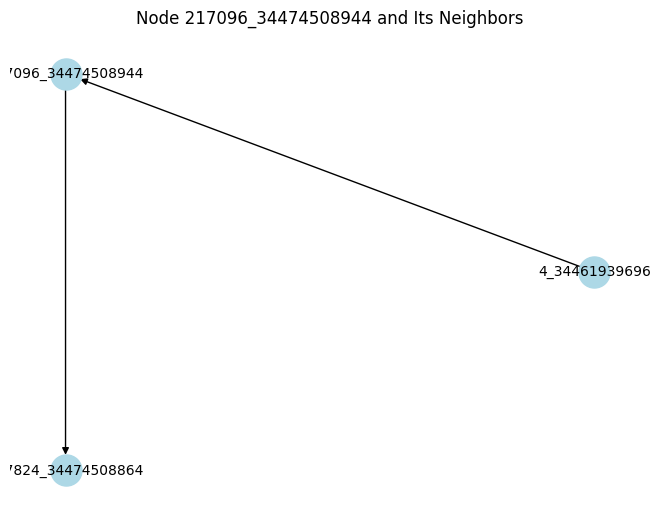

Timestamp  From Bank      Account  To Bank    Account.1  \
2292712 2022-09-05 00:06:00     122151  34639814032    17708  34673305040   

         Payment Format  Conversion  Amount in US Dollar  
2292712          0.2606         1.0                19.67

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
225231 2022-09-01 00:10:00          3  34437259648    13029  34441466064   

        Payment Format  Conversion  Amount in US Dollar  
225231          0.1183     0.00899          62504.74788

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3267278 2022-09-07 00:01:00      16678  34461605904        4  34463544144   

         Payment Format  Conversion  Amount in US Dollar  
3267278          0.2606    0.005884              40.2193

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1007666 2022-09-01 20:36:00      20861  34682274096    43923  34682272528   
1817841 2022-09-02 22:26:00     220541  34484528896    20861  34682274096   

         Payment Format  Conversion  Amount in US Dollar  
1007666          0.1183     0.44614           32281.1440  
1817841          0.3671     0.44614            3539.0432

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 1817841
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


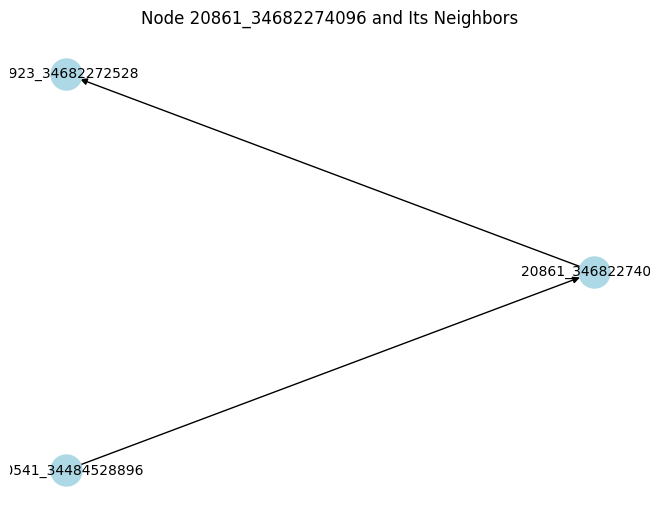

Timestamp  From Bank      Account  To Bank    Account.1  \
56805 2022-09-01 00:21:00      18015  34504679616    19729  34504630288   

       Payment Format  Conversion  Amount in US Dollar  
56805          0.3671         1.0            1045075.0

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2960656 2022-09-06 09:25:00      35925  34632262304    13264  34632263328   

         Payment Format  Conversion  Amount in US Dollar  
2960656          0.1183         1.0              3597.83

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2781276 2022-09-06 00:04:00       1916  34635637216    19777  34494097440   

         Payment Format  Conversion  Amount in US Dollar  
2781276          0.2606     0.44614             114.2848

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1966908 2022-09-03 10:18:00     147863  34668895872    46232  34668898640   

         Payment Format  Conversion  Amount in US Dollar  
1966908          0.1183     0.44614            4570.9104

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3256267 2022-09-07 00:14:00      16109  34593143600    16333  34675229312   
3739042 2022-09-08 00:25:00      12585  34593157728    16333  34675229312   

         Payment Format  Conversion  Amount in US Dollar  
3256267          0.2606         1.0                23.03  
3739042          0.2606         1.0                 0.69

Number of account in: 2
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


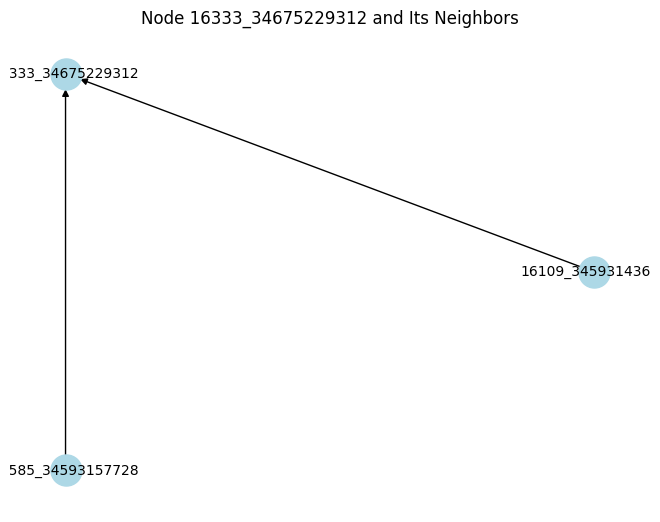

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
99435 2022-09-01 00:01:00      37774  34634238384    13327  34634242736   

       Payment Format  Conversion  Amount in US Dollar  
99435          0.1183         1.0             46090.09

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4313478 2022-09-09 03:16:00       3229  34590837120   130449  34590837904   

         Payment Format  Conversion  Amount in US Dollar  
4313478          0.1183         1.0              6090.36

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4237659 2022-09-09 00:17:00      25534  34519648000      210  34603589440   

         Payment Format  Conversion  Amount in US Dollar  
4237659          0.2606    0.005088              60.8456

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1003533 2022-09-01 20:53:00     214615  34679517328    24161  34679517088   

         Payment Format  Conversion  Amount in US Dollar  
1003533          0.1183         1.0              2353.68

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
99184 2022-09-01 00:26:00      21258  34633848896   130425  34633849136   

       Payment Format  Conversion  Amount in US Dollar  
99184          0.1183         1.0            2147273.0

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2771912 2022-09-06 00:05:00       2952  34503179200   111764  34504030432   

         Payment Format  Conversion  Amount in US Dollar  
2771912          0.2606         1.0               118.06

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
913108  2022-09-01 17:52:00     348562  34665251248    48755  34665251088   
2417081 2022-09-05 05:57:00      48755  34665251088   148785  34665896368   

         Payment Format  Conversion  Amount in US Dollar  
913108           0.1183    0.009407               0.0027  
2417081          0.1183    0.009407            4567.4469

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 913108
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  1
 Check Fan_in or Fan_out scenario
Random scenario


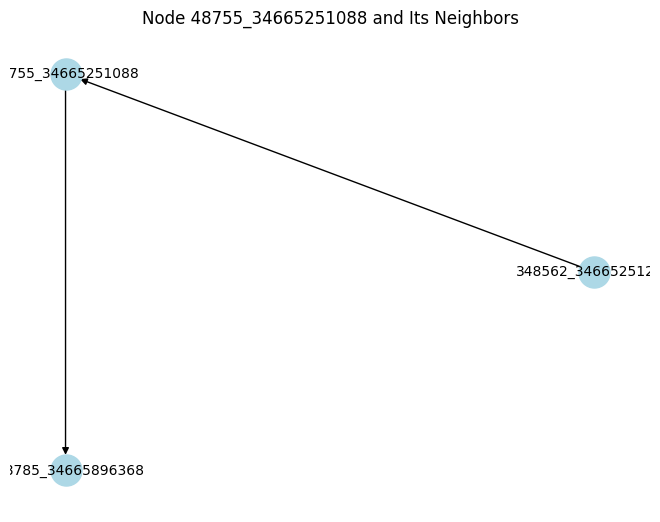

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1263864 2022-09-02 04:20:00     210292  34430069008    10581  34425093200   

         Payment Format  Conversion  Amount in US Dollar  
1263864          0.1183    0.006787          1933.564392

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
809750  2022-09-01 14:58:00      24922  34513776880    25534  34516577888   
1884765 2022-09-03 00:12:00     225215  34517271408    25534  34516577888   
2787015 2022-09-06 00:06:00        210  34520914320    25534  34516577888   

         Payment Format  Conversion  Amount in US Dollar  
809750           0.3671    0.005088         2.404634e+07  
1884765          0.2606    0.005088         2.995540e+02  
2787015          0.2606    0.005088         1.142736e+02

Number of account in: 3
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


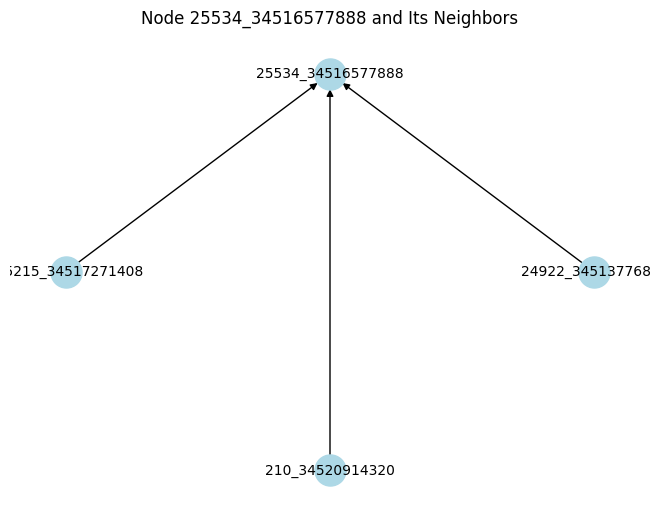

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
215958 2022-09-01 00:23:00      10605  34427407104   110057  34427978160   

        Payment Format  Conversion  Amount in US Dollar  
215958          0.3671    0.006787         55351.145736

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4556901 2022-09-09 12:21:00       3489  34488250576    17769  34488247936   
5020215 2022-09-10 16:54:00      17769  34488247936     3489  34488250576   

         Payment Format  Conversion  Amount in US Dollar  
4556901          0.3671     0.44614           31339.9968  
5020215          0.1183     0.44614            1493.4416

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 5020215
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


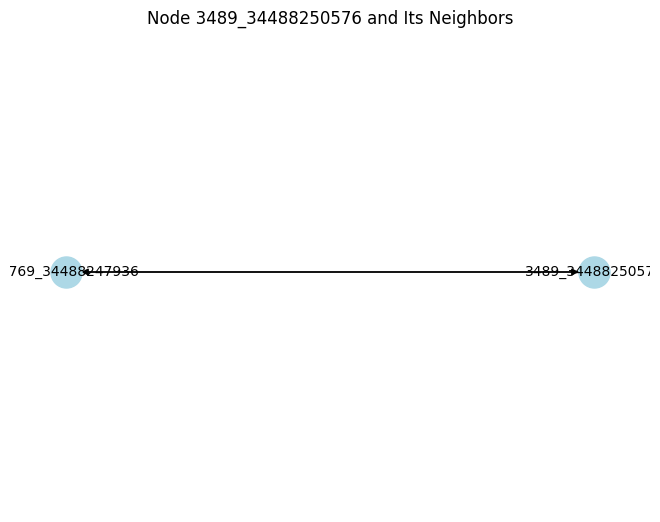

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
514981  2022-09-01 06:00:00       9482  34541437344    25637  34541436704   
1319048 2022-09-02 06:25:00       9482  34541437344   215687  34541437184   

         Payment Format  Conversion  Amount in US Dollar  
514981           0.3671         1.0           7039836.00  
1319048          0.1183         1.0               576.26

Number of account in: 0
Number of account out: 2
 Check Fan_in or Fan_out scenario
Fan_out scenario


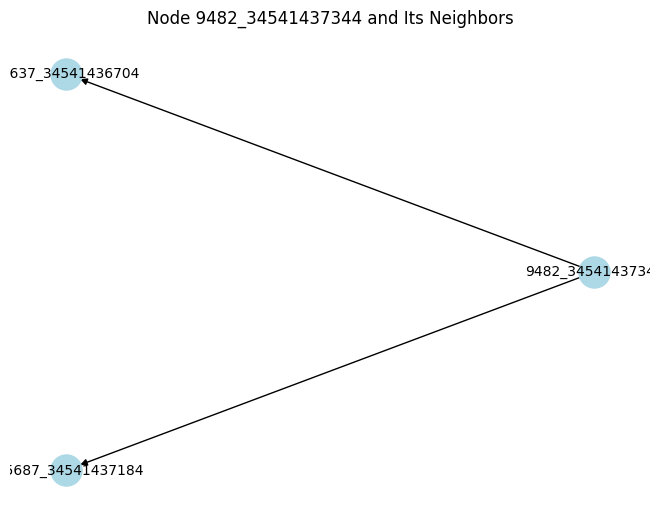

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
32      2022-09-01 00:26:00         10  34360099072     1688  34366018608   
1125246 2022-09-02 00:04:00     140020  34657372704     1688  34366018608   
1124936 2022-09-02 00:05:00     134140  34646367104     1688  34366018608   
1126609 2022-09-02 00:11:00     116715  34698946880     1688  34366018608   
1545540 2022-09-02 13:13:00       1688  34366018608   244187  34634319632   
1876952 2022-09-03 00:05:00      29404  34697513440     1688  34366018608   
2082933 2022-09-04 00:11:00     141045  34623911296     1688  34366018608   
2081531 2022-09-04 00:11:00      31208  34553052960     1688  34366018608   
2080703 2022-09-04 00:24:00       1467  34503962432     1688  34366018608   
2291116 2022-09-05 00:04:00      29802  34577995488     1688  34366018608   
2773236 2022-09-06 00:07:00      10232  34560214656     1688  34366018608   
2773092 2022-09-06 00:16:00      16586  34556952032     1688  34366018608   
2774627 2022-09-06 00:19:00       2952  34611318064     1688  34366018608   
2776119 2022-09-06 00:23:00     235440  34679668624     1688  34366018608   
3257312 2022-09-07 00:03:00     115359  34639768544     1688  34366018608   
3254669 2022-09-07 00:12:00      15980  34535152384     1688  34366018608   
3257005 2022-09-07 00:22:00      14325  34626663008     1688  34366018608   
3258712 2022-09-07 00:26:00     238038  34694284464     1688  34366018608   
3733059 2022-09-08 00:10:00         12  34366595504     1688  34366018608   
3735644 2022-09-08 00:22:00       8771  34455668784     1688  34366018608   
4224563 2022-09-09 00:06:00       8805  34663772048     1688  34366018608   
4224541 2022-09-09 00:14:00      44782  34663418544     1688  34366018608   

         Payment Format  Conversion  Amount in US Dollar  
32               0.1183    1.000000            159271.00  
1125246          0.2606    1.000000                 1.95  
1124936          0.2606    1.000000               132.03  
1126609          0.2606    1.000000                16.83  
1545540          0.3671    0.005243             54290.04  
1876952          0.2606    1.000000                38.06  
2082933          0.2606    1.000000               139.84  
2081531          0.2606    1.000000                44.62  
2080703          0.2606    1.000000                36.89  
2291116          0.2606    1.000000               132.87  
2773236          0.2606    1.000000                 5.22  
2773092          0.2606    1.000000               135.88  
2774627          0.2606    1.000000               105.75  
2776119          0.2606    1.000000                45.01  
3257312          0.2606    1.000000                 2.47  
3254669          0.2606    1.000000               103.89  
3257005          0.2606    1.000000               139.11  
3258712          0.2606    1.000000                 3.48  
3733059          0.2606    1.000000                25.22  
3735644          0.2606    1.000000               931.78  
4224563          0.2606    1.000000                42.71  
4224541          0.2606    1.000000                49.57

Number of account in: 21
Number of account out: 1
Laaast incoming indeeex 4224541
Max consecutive incoming trans : 17
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
585198 2022-09-01 08:20:00     352822  34688053632   227786  34688036944   

        Payment Format  Conversion  Amount in US Dollar  
585198          0.0338         1.0              4185.56

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1911696 2022-09-03 03:08:00     235319  34575142016    34032  34575078768   

         Payment Format  Conversion  Amount in US Dollar  
1911696          0.1183    0.002901           50264.8806

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
237895  2022-09-01 00:08:00     317520  34466328944   117143  34466327904   
1076826 2022-09-01 22:34:00     117143  34466327904       10  34466328144   

         Payment Format  Conversion  Amount in US Dollar  
237895           0.1183    0.005884              0.00891  
1076826          0.1183    0.005884           1113.90499

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 237895
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  1
 Check Fan_in or Fan_out scenario
Random scenario


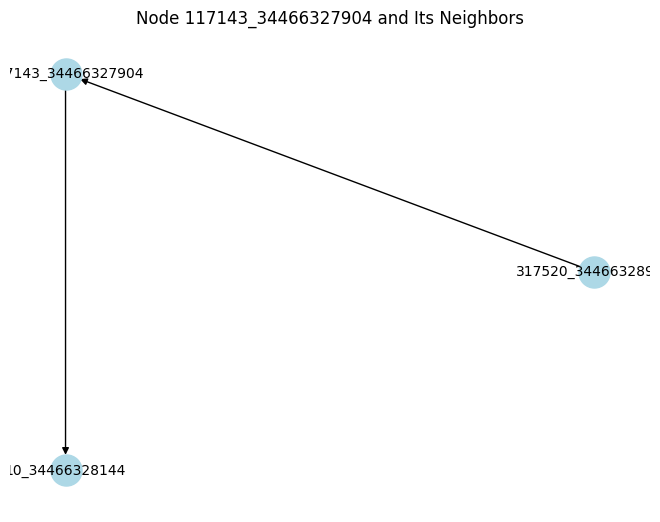

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
250037  2022-09-01 00:27:00      22575  34502809664        7  34498638032   
742183  2022-09-01 12:51:00      23331  34502606576    22575  34502809664   
1327850 2022-09-02 06:02:00      22575  34502809664   122463  34674991184   
2091650 2022-09-04 00:08:00      22575  34502809664    22575  34687494160   
4884074 2022-09-10 00:22:00      22575  34502809664       15  34416976240   

         Payment Format  Conversion  Amount in US Dollar  
250037           0.2606    0.006711            10.990900  
742183           0.3671    0.006711        113020.250000  
1327850          0.3671    0.006711         43315.294100  
2091650          0.2606    0.006711           243.437300  
4884074          0.2606    0.006787            14.292216

Number of account in: 1
Number of account out: 4
Laaast incoming indeeex 742183
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  3
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
197820 2022-09-01 00:05:00       3878  34703832400   249007  34703873136   

        Payment Format  Conversion  Amount in US Dollar  
197820          0.1183     0.44614            3311.3696

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
239498  2022-09-01 00:12:00      18405  34472730992   217824  34472707808   
2303021 2022-09-05 00:11:00     217824  34472707808   218638  34474950496   
2785357 2022-09-06 00:29:00     217824  34472707808   117070  34465291584   

         Payment Format  Conversion  Amount in US Dollar  
239498           0.1183    0.005884         1.273885e+06  
2303021          0.2606    0.005884         3.896508e+01  
2785357          0.2606    0.005884         2.597100e+00

Number of account in: 1
Number of account out: 2
Laaast incoming indeeex 239498
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  2
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1276949 2022-09-02 04:43:00      23344  34494456960     8455  34539643456   
2780945 2022-09-06 00:16:00     120709  34601182720     8455  34539643456   

         Payment Format  Conversion  Amount in US Dollar  
1276949          0.3671     0.44614            4474.9824  
2780945          0.2606     0.44614             185.6848

Number of account in: 2
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


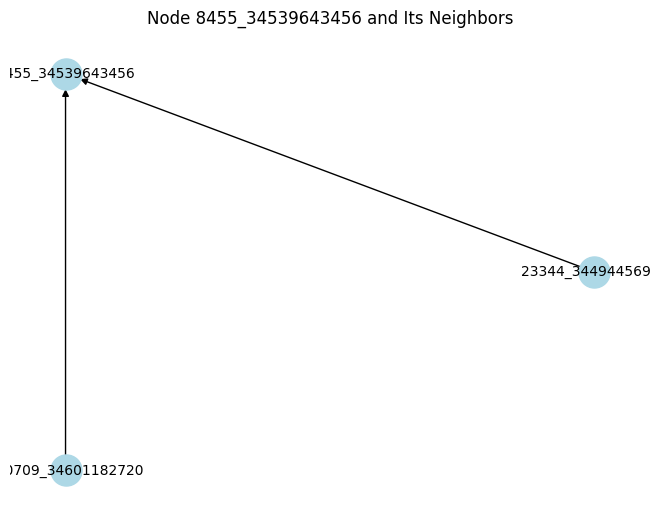

Timestamp  From Bank      Account  To Bank    Account.1  \
3738099 2022-09-08 00:13:00     232555  34561082352    17753  34609634464   

         Payment Format  Conversion  Amount in US Dollar  
3738099          0.2606         1.0                10.51

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4875825 2022-09-10 00:11:00       3229  34649098816     8771  34478329008   

         Payment Format  Conversion  Amount in US Dollar  
4875825          0.2606         1.0                 5.75

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
284235 2022-09-01 00:27:00      36868  34586703664   235551  34586695888   

        Payment Format  Conversion  Amount in US Dollar  
284235          0.1183    0.001172              5302.71

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1523324 2022-09-02 12:46:00       8074  34489671872    23691  34489679440   

         Payment Format  Conversion  Amount in US Dollar  
1523324          0.1183     0.44614             4094.552

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3058607 2022-09-06 14:12:00       6276  34652005744    22828  34651949200   

         Payment Format  Conversion  Amount in US Dollar  
3058607          0.1183         1.0              2386.25

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
50357   2022-09-01 00:24:00       4242  34400707824     6276  34483855856   
2079025 2022-09-04 00:00:00      21575  34410495760     4242  34400707824   
4219287 2022-09-09 00:05:00      11296  34473446016     4242  34400707824   

         Payment Format  Conversion  Amount in US Dollar  
50357            0.3671         1.0             91957.87  
2079025          0.2606         1.0                28.31  
4219287          0.2606         1.0               139.78

Number of account in: 2
Number of account out: 1
Laaast incoming indeeex 4219287
Max consecutive incoming trans : 2
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
621302  2022-09-01 09:29:00      12461  34470757664    18460  34607974240   
2296924 2022-09-05 00:29:00       1502  34487399536    12461  34470757664   

         Payment Format  Conversion  Amount in US Dollar  
621302           0.3671     0.44614            9238.8352  
2296924          0.2606     0.44614             115.4832

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 2296924
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


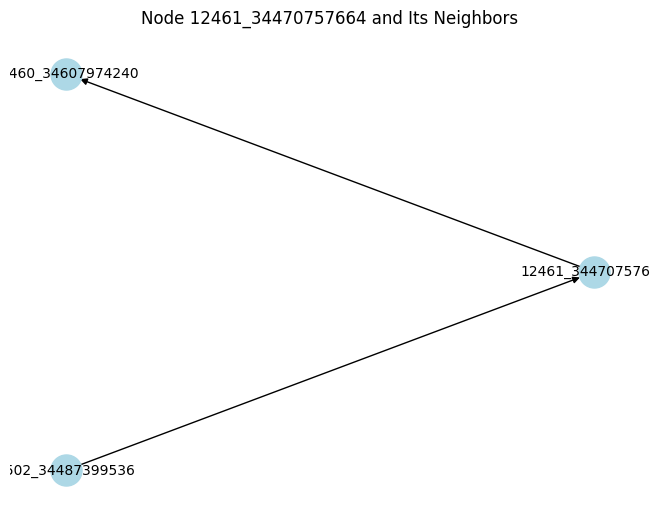

Timestamp  From Bank      Account  To Bank    Account.1  \
877454  2022-09-01 16:40:00     229122  34537550720    28237  34537550800   
2717365 2022-09-05 21:28:00     229122  34537550720   128727  34537551040   

         Payment Format  Conversion  Amount in US Dollar  
877454           0.1183    0.004955         4.573434e+06  
2717365          0.1183    0.004955         3.156030e+03

Number of account in: 0
Number of account out: 2
 Check Fan_in or Fan_out scenario
Fan_out scenario


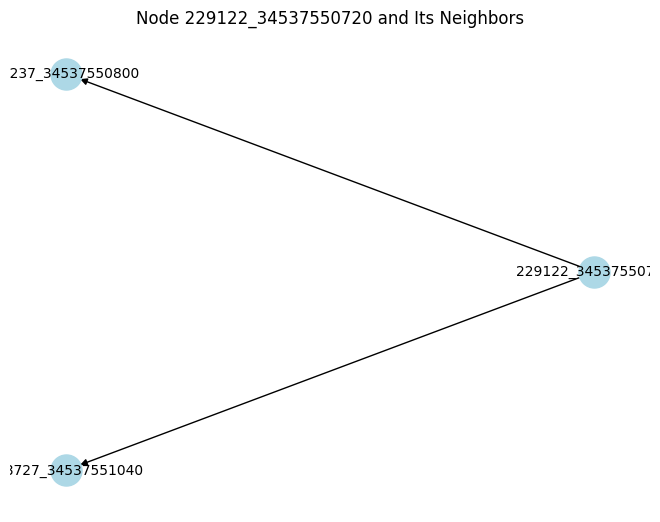

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4709019 2022-09-09 17:30:00     240304  34611904272   240229  34611838512   

         Payment Format  Conversion  Amount in US Dollar  
4709019          0.1183    0.012866            3827.3736

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1070359 2022-09-01 22:40:00     215897  34675987984    39279  34675995104   
4674672 2022-09-09 16:30:00     215897  34675987984   228634  34675994160   

         Payment Format  Conversion  Amount in US Dollar  
1070359          0.3671         1.0               1187.0  
4674672          0.1183         1.0               1099.6

Number of account in: 0
Number of account out: 2
 Check Fan_in or Fan_out scenario
Fan_out scenario


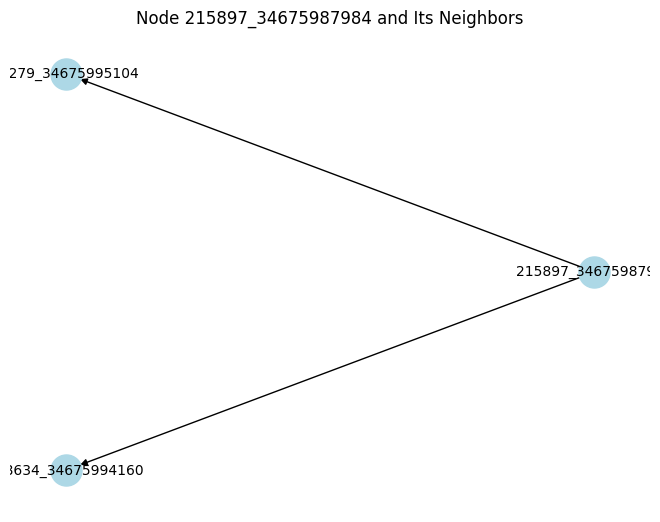

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
721726 2022-09-01 12:15:00      21745  34438848544     2915  34566716288   

        Payment Format  Conversion  Amount in US Dollar  
721726          0.3671     0.44614           24920.3248

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
9653 2022-09-01 00:09:00      32881  34377201840     1686  34377201600   

      Payment Format  Conversion  Amount in US Dollar  
9653          0.1183         1.0             26938.58

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
237185 2022-09-01 00:27:00     316917  34464867120   116904  34464335456   

        Payment Format  Conversion  Amount in US Dollar  
237185          0.3671    0.005884              0.00011

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4236833 2022-09-09     222819  34505302464      212  34360357424   

         Payment Format  Conversion  Amount in US Dollar  
4236833          0.2606    0.006711               4.6112

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
810937 2022-09-01 14:56:00     335390  34584144720      211  34584144640   

        Payment Format  Conversion  Amount in US Dollar  
810937          0.1183    0.001172               0.0021

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3721732 2022-09-07 23:26:00     135155  34585218528      211  34585219072   

         Payment Format  Conversion  Amount in US Dollar  
3721732          0.1183    0.001172            1457.2404

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3264714 2022-09-07 00:06:00         20  34411401600   120193  34499038672   

         Payment Format  Conversion  Amount in US Dollar  
3264714          0.2606    0.010654              21.8652

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1832853 2022-09-02 22:43:00      14011  34487110112    18428  34656554000   
1962849 2022-09-03 09:40:00      18428  34656554000    14011  34487110112   
1962851 2022-09-03 09:43:00      16941  34656555920    14011  34487110112   
1962850 2022-09-03 09:54:00     131167  34656556000    14011  34487110112   

         Payment Format  Conversion  Amount in US Dollar  
1832853          0.1183     0.44614            4578.0560  
1962849          0.1183     0.44614            1190.4368  
1962851          0.1183     0.44614            2122.6576  
1962850          0.1183     0.44614            4353.4736

Number of account in: 3
Number of account out: 1
Laaast incoming indeeex 1962850
Max consecutive incoming trans : 3
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2648 2022-09-01 00:04:00       1467  34361758672        1  34362887728   

      Payment Format  Conversion  Amount in US Dollar  
2648          0.3671         1.0            2432391.0

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2287883 2022-09-05 00:07:00      11030  34444847968     1457  34389861472   

         Payment Format  Conversion  Amount in US Dollar  
2287883          0.2606         1.0                42.81

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
202806  2022-09-01 00:26:00       9417  34435856304    18200  34435859216   
1134068 2022-09-02 00:29:00      18200  34435859216     9587  34510132624   
1881606 2022-09-03 00:08:00      18200  34435859216        3  34417484640   
2089036 2022-09-04 00:27:00      18200  34435859216    23146  34546070288   
2782756 2022-09-06 00:12:00      18200  34435859216        3  34411205488   
3747598 2022-09-08 00:28:00      18200  34435859216   225622  34584934240   
4881404 2022-09-10 00:26:00      18200  34435859216     1267  34611380960   

         Payment Format  Conversion  Amount in US Dollar  
202806           0.3671    0.010654         3.715327e+07  
1134068          0.2606    0.010654         9.301600e+00  
1881606          0.2606    0.010654         1.662570e+02  
2089036          0.2606    0.010654         4.414200e+01  
2782756          0.2606    0.010654         3.117380e+01  
3747598          0.2606    0.010654         2.129260e+01  
4881404          0.2606    0.010654         9.549400e+00

Number of account in: 1
Number of account out: 6
Laaast incoming indeeex 202806
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  6
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1502650 2022-09-02 12:15:00     215897  34467741056    12979  34467745024   
2293918 2022-09-05 00:06:00     122702  34686890720   215897  34467741056   

         Payment Format  Conversion  Amount in US Dollar  
1502650          0.1183         1.0           1387971.00  
2293918          0.2606         1.0                 0.03

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 2293918
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


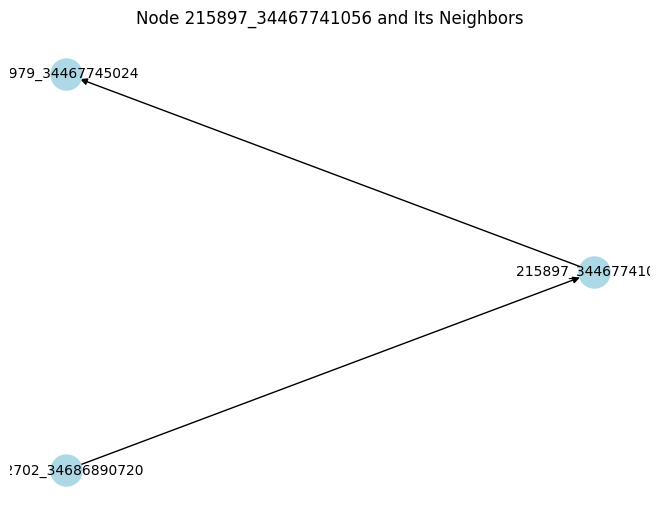

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2172230 2022-09-04 09:31:00     243614  34630747504   143493  34630747584   

         Payment Format  Conversion  Amount in US Dollar  
2172230          0.1183    0.005243           13436.5476

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3383376 2022-09-07 06:01:00      11318  34511078736     2843  34511089904   
3383378 2022-09-07 06:01:00     214609  34511083904     2843  34511089904   
3383381 2022-09-07 06:10:00       2952  34511084144     2843  34511089904   
3383377 2022-09-07 06:17:00      29685  34511081584     2843  34511089904   
3383379 2022-09-07 06:18:00      18015  34511081264     2843  34511089904   
3383380 2022-09-07 06:23:00     221868  34511093616     2843  34511089904   

         Payment Format  Conversion  Amount in US Dollar  
3383376          0.1183         1.0               782.34  
3383378          0.1183         1.0               265.14  
3383381          0.1183         1.0              2348.17  
3383377          0.1183         1.0              3022.20  
3383379          0.1183         1.0              4115.14  
3383380          0.1183         1.0              2852.02

Number of account in: 6
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


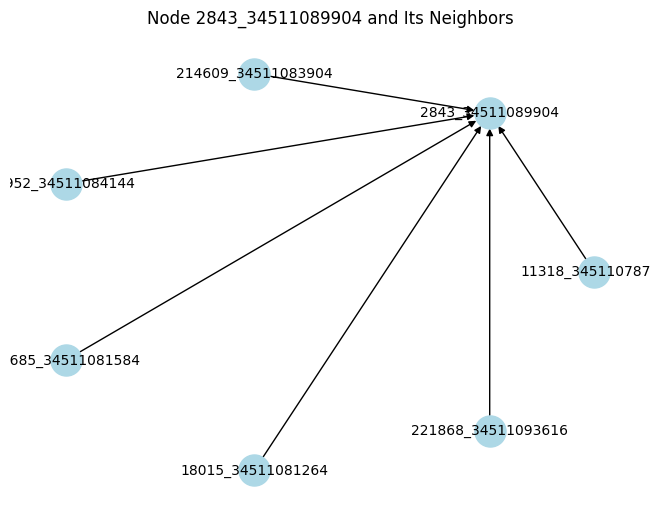

Timestamp  From Bank      Account  To Bank    Account.1  \
1204495 2022-09-02 02:05:00         28  34529193776      211  34530135232   
1637050 2022-09-02 16:15:00         70   4299327648       28  34529193776   

         Payment Format  Conversion  Amount in US Dollar  
1204495          0.3671    0.004955           35918.7220  
1637050          0.3671    0.004955           21595.9432

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 1637050
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


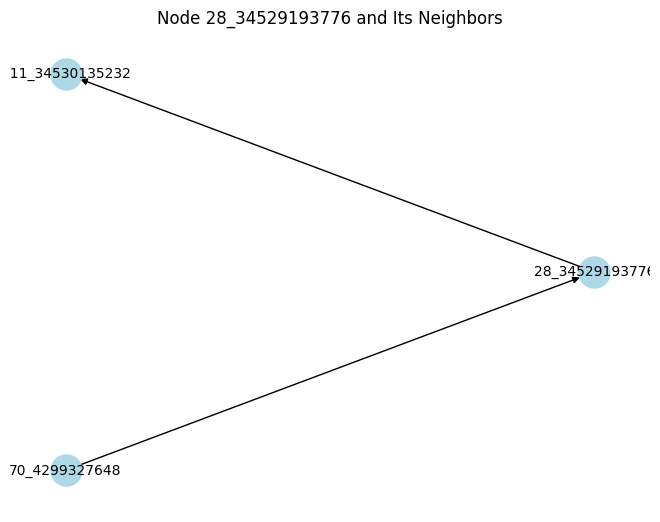

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
84233   2022-09-01 00:13:00      13037  34538139648    17400  34586907296   
3738025 2022-09-08 00:28:00     129470  34558888160    17400  34586907296   
4872229 2022-09-10 00:14:00      19329  34458204416    17400  34586907296   

         Payment Format  Conversion  Amount in US Dollar  
84233            0.3671         1.0          31505376.00  
3738025          0.2606         1.0                20.52  
4872229          0.2606         1.0                 7.42

Number of account in: 3
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


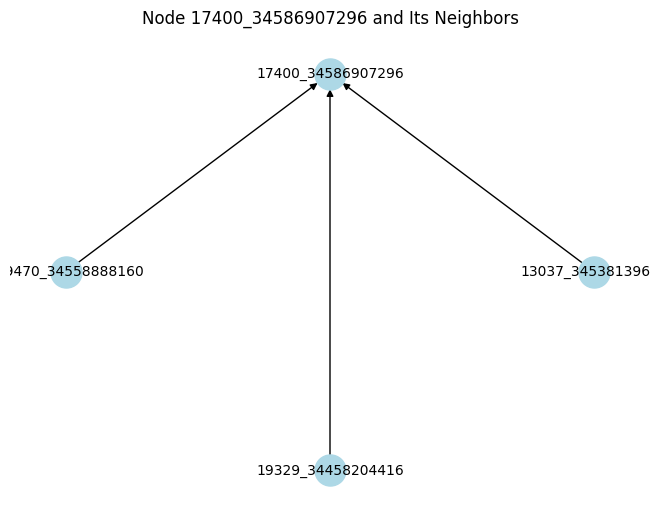

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1283186 2022-09-02 04:46:00         70   4299327936    43735  34631656272   
1992587 2022-09-03 13:23:00      43735  34631656272   143598  34631657632   

         Payment Format  Conversion  Amount in US Dollar  
1283186          0.3671    0.005243            7520.6124  
1992587          0.1183    0.005243            4602.1668

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 1283186
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  1
 Check Fan_in or Fan_out scenario
Random scenario


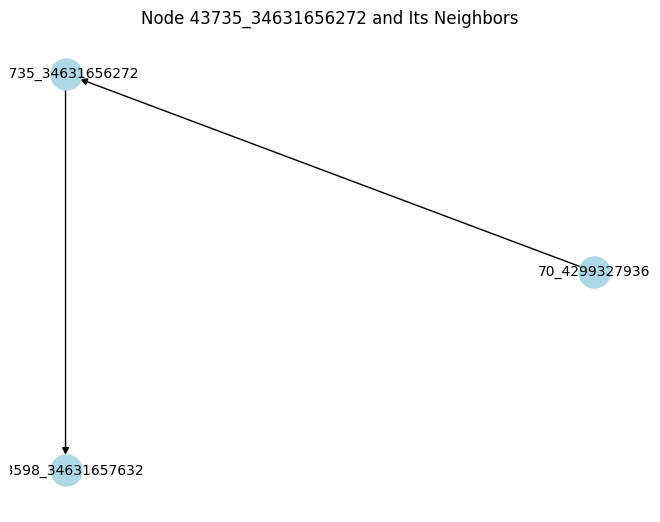

Timestamp  From Bank      Account  To Bank    Account.1  \
4895658 2022-09-10 01:00:00     220504  34490012064      211  34490011744   
4895659 2022-09-10 01:29:00         26  34490027632      211  34490011744   
4895657 2022-09-10 01:29:00     220572  34490011824      211  34490011744   

         Payment Format  Conversion  Amount in US Dollar  
4895658          0.1183    0.006711            3282.4801  
4895659          0.1183    0.006711             638.3630  
4895657          0.1183    0.006711            4764.0770

Number of account in: 3
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


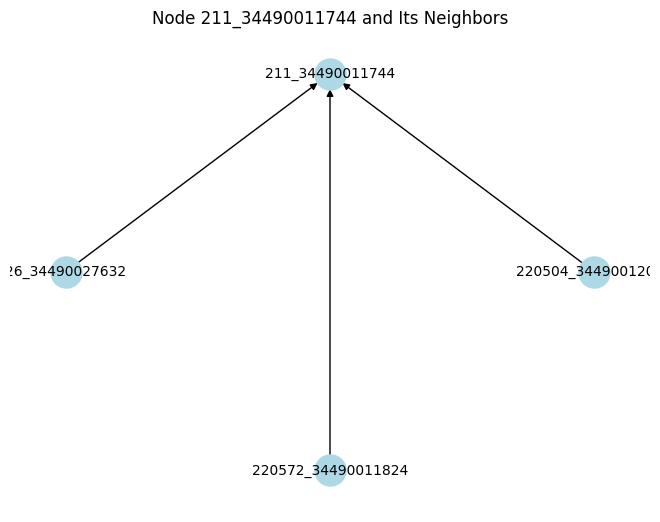

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3033974 2022-09-06 12:35:00      23497  34538690448   220504  34538628752   

         Payment Format  Conversion  Amount in US Dollar  
3033974          0.1183    0.006711            3606.3776

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
582475 2022-09-01 08:27:00     326869  34523769104   226041  34523839120   

        Payment Format  Conversion  Amount in US Dollar  
582475          0.3671         1.0                 0.01

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2914080 2022-09-06 06:47:00     218897  34488019232    20727  34488010096   

         Payment Format  Conversion  Amount in US Dollar  
2914080          0.1183     0.44614            2851.4416

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1383653 2022-09-02 08:29:00       7042  34666169680   240648  34697080016   
4042906 2022-09-08 15:15:00      18511  34666169600     7042  34666169680   

         Payment Format  Conversion  Amount in US Dollar  
1383653          0.3671         1.0            139386.50  
4042906          0.1183         1.0              1485.92

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 4042906
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


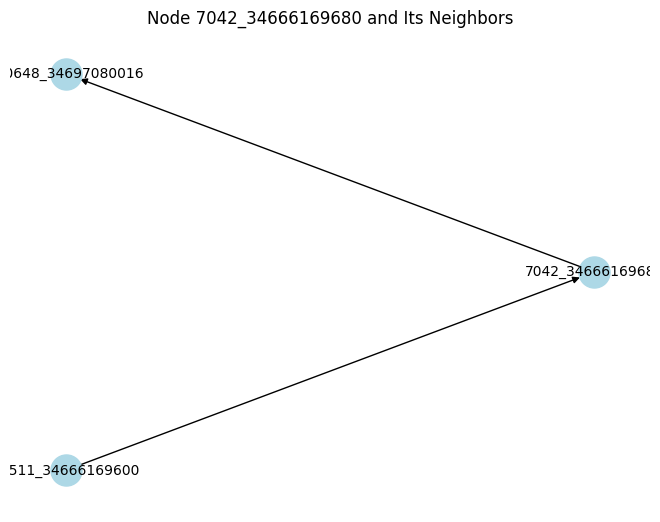

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
4771803 2022-09-09 20:09:00     125164  34540817360   218346  34540817120   
4771804 2022-09-09 20:13:00      25536  34647247104   218346  34540817120   
4771805 2022-09-09 20:27:00     238387  34540817520   218346  34540817120   

         Payment Format  Conversion  Amount in US Dollar  
4771803          0.1183     0.44614           12303.9840  
4771804          0.1183     0.44614             962.0464  
4771805          0.1183     0.44614           18313.1088

Number of account in: 3
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


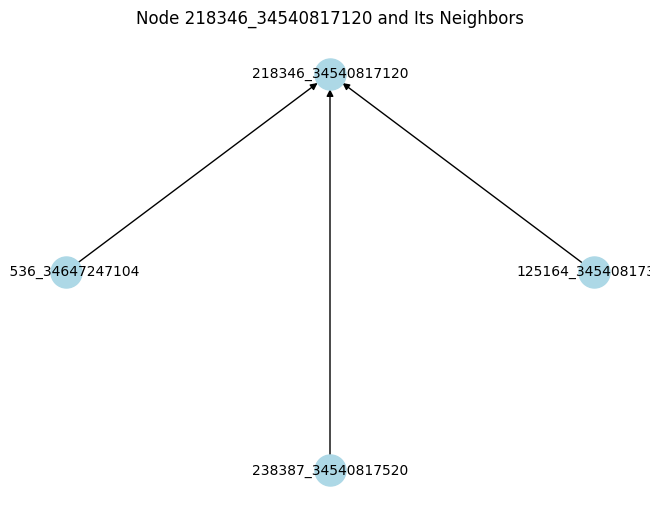

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1076420 2022-09-01 22:32:00     312835  34452736752   214308  34452736512   

         Payment Format  Conversion  Amount in US Dollar  
1076420          0.1183     0.00899          25601.36256

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
258563  2022-09-01 00:12:00      24922  34516605536   225215  34521944848   
2304476 2022-09-05 00:18:00     225454  34516592704   225215  34521944848   

         Payment Format  Conversion  Amount in US Dollar  
258563           0.2606    0.005088             102.0832  
2304476          0.2606    0.005088              65.1776

Number of account in: 2
Number of account out: 0
 Check Fan_in or Fan_out scenario
Fan_in scenario


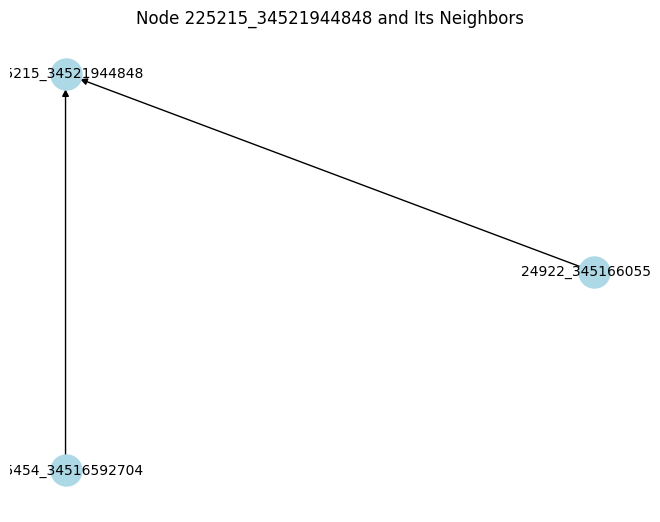

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1926837 2022-09-03 05:18:00      23525  34656250288   218267  34656246000   

         Payment Format  Conversion  Amount in US Dollar  
1926837          0.1183     0.44614             705.8016

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
3745494 2022-09-08 00:28:00     223090  34570166464     1522  34392795856   

         Payment Format  Conversion  Amount in US Dollar  
3745494          0.2606     0.44614             122.1248

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
119529 2022-09-01 00:20:00     333577  34690921024   132306  34690920944   

        Payment Format  Conversion  Amount in US Dollar  
119529          0.1183         1.0              2601.97

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
2100258 2022-09-04 00:32:00     250068  34666025488    48308  34666026048   
2553865 2022-09-05 12:30:00      48308  34666026048   250068  34666025488   

         Payment Format  Conversion  Amount in US Dollar  
2100258          0.1183    0.009407            3931.4376  
2553865          0.1183    0.009407            4274.2647

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 2553865
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


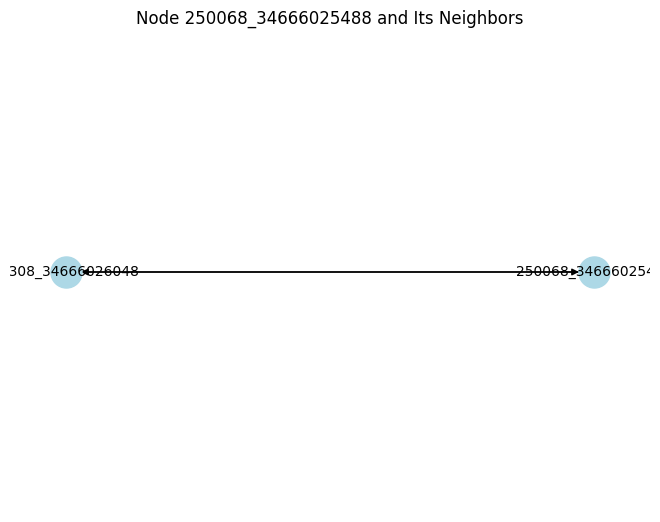

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
325041  2022-09-01 00:19:00        126  34701106273      126  34685071665   
444846  2022-09-01 03:44:00     154653  34701098657      126  34701106273   
2096104 2022-09-04 00:11:00        126  34701106273   254958  34695510913   
2309644 2022-09-05 00:25:00        126  34701106273    54219  34695355985   
3274022 2022-09-07 00:04:00        126  34701106273    54348  34699098497   
4243159 2022-09-09 00:16:00        126  34701106273   255063  34703595393   

         Payment Format  Conversion  Amount in US Dollar  
325041           0.0288    0.002383           499.103046  
444846           0.0288    0.002383        242754.400000  
2096104          0.0288    0.002383           554.056574  
2309644          0.0288    0.002383           231.071844  
3274022          0.0288    0.002383           230.616680  
4243159          0.0288    0.002383          2215.498032

Number of account in: 1
Number of account out: 5
Laaast incoming indeeex 444846
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  4
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
730935  2022-09-01 12:58:00       1665  34412388608     6276  34412388208   
1117955 2022-09-02 00:05:00       6276  34412388208    36056  34646047312   
1871641 2022-09-03 00:28:00       6276  34412388208   115359  34692620224   
2079063 2022-09-04 00:12:00       6276  34412388208        1  34677972640   
2287106 2022-09-05 00:24:00       6276  34412388208    12735  34422134976   
2769768 2022-09-06 00:25:00       6276  34412388208   123390  34675693184   

         Payment Format  Conversion  Amount in US Dollar  
730935           0.3671         1.0              2234.00  
1117955          0.2606         1.0                78.42  
1871641          0.2606         1.0               282.03  
2079063          0.2606         1.0                37.24  
2287106          0.2606         1.0                75.49  
2769768          0.2606         1.0               171.47

Number of account in: 1
Number of account out: 5
Laaast incoming indeeex 730935
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  5
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
643734 2022-09-01 09:36:00     238190  34618586608      118  34618586928   

        Payment Format  Conversion  Amount in US Dollar  
643734          0.1183    0.012866              28681.0

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1087135 2022-09-01 23:07:00     113779  34677438880   250298  34677448368   
1125838 2022-09-02 00:06:00     250298  34677448368      795  34556138464   
1876476 2022-09-03 00:17:00     250298  34677448368   234347  34571722864   
2293540 2022-09-05 00:06:00     250298  34677448368     2824  34628301232   
3740952 2022-09-08 00:14:00     250298  34677448368     2627  34445053968   
4224928 2022-09-09 00:12:00     250298  34677448368    17425  34420270176   
4876299 2022-09-10 00:23:00     250298  34677448368    38132  34627309632   

         Payment Format  Conversion  Amount in US Dollar  
1087135          0.3671         1.0               785.00  
1125838          0.2606         1.0                28.77  
1876476          0.2606         1.0               166.12  
2293540          0.2606         1.0                44.41  
3740952          0.2606         1.0                46.24  
4224928          0.2606         1.0                36.48  
4876299          0.2606         1.0                70.75

Number of account in: 1
Number of account out: 6
Laaast incoming indeeex 1087135
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  6
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
218200 2022-09-01 00:04:00     310073  34433188176       15  34433128944   

        Payment Format  Conversion  Amount in US Dollar  
218200          0.3671    0.006787             0.000648

Number of account in: 1
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1488094 2022-09-02 11:54:00     110603  34455038480    28771  34519430528   
1872974 2022-09-03 00:17:00      11471  34488113632   110603  34455038480   

         Payment Format  Conversion  Amount in US Dollar  
1488094          0.3671         1.0            169535.91  
1872974          0.2606         1.0                 7.60

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 1872974
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


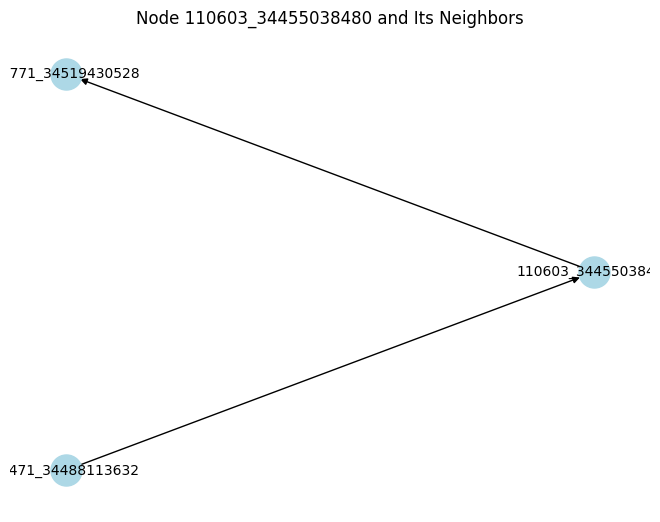

Timestamp  From Bank      Account  To Bank    Account.1  \
312924  2022-09-01 00:07:00      45279  34655250176   244192  34655257600   
1887797 2022-09-03 00:21:00     244192  34655257600   243614  34643729520   
2095231 2022-09-04 00:07:00     244192  34655257600    43049  34625485680   
2308572 2022-09-05 00:03:00     244192  34655257600    43735  34653921280   
2790824 2022-09-06 00:23:00     244192  34655257600   246162  34647919504   
3272998 2022-09-07 00:20:00     244192  34655257600   244192  34638136192   
3755853 2022-09-08 00:17:00     244192  34655257600    21831  34377398688   

         Payment Format  Conversion  Amount in US Dollar  
312924           0.3671    0.005243            1045.8000  
1887797          0.2606    0.005243               6.8096  
2095231          0.2606    0.005243              51.4024  
2308572          0.2606    0.005243             144.7040  
2790824          0.2606    0.005243               8.4924  
3272998          0.2606    0.005243             102.2028  
3755853          0.2606    0.446140             100.9120

Number of account in: 1
Number of account out: 6
Laaast incoming indeeex 312924
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  6
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
1998688 2022-09-03 14:04:00      26818  34422724176    15055  34422724256   
4796260 2022-09-09 21:04:00      15055  34422724256    26818  34422724176   

         Payment Format  Conversion  Amount in US Dollar  
1998688          0.1183     0.44614             1012.088  
4796260          0.1183     0.44614             4214.560

Number of account in: 1
Number of account out: 1
Laaast incoming indeeex 4796260
Max consecutive incoming trans : 1
Max consecutive outgoing trans :  0
 Check Fan_in or Fan_out scenario
Random scenario


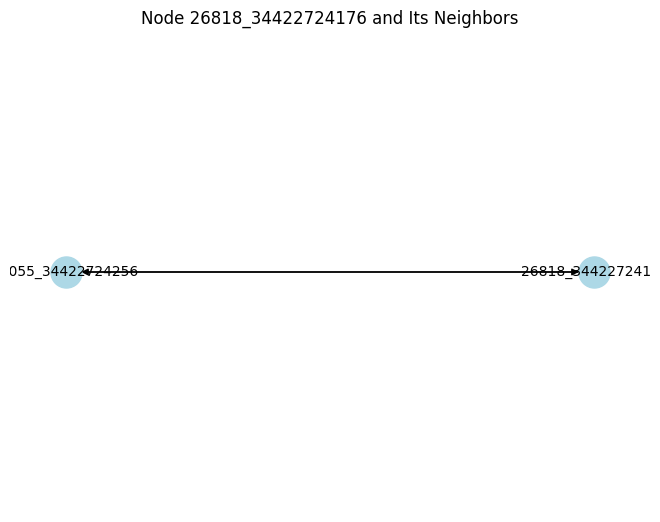

Empty DataFrame
Columns: [Timestamp, From Bank, Account, To Bank, Account.1, Payment Format, Conversion, Amount in US Dollar]
Index: []

Number of account in: 0
Number of account out: 0
 Check Fan_in or Fan_out scenario


Timestamp  From Bank      Account  To Bank    Account.1  \
190914 2022-09-01 00:06:00     147042  34672311456   122094  34672300320   

        Payment Format  Conversion  Amount in US Dollar  
190914          0.3671     0.44614            6715.8448

Number of account in: 0
Number of account out: 1
 Check Fan_in or Fan_out scenario


In [ ]:
def filter_dataframe(bank_id,account_id):
    filtered_df= df_HI_Small_csv[((df_HI_Small_csv['From Bank']== bank_id) & (df_HI_Small_csv['Account']== account_id)) | ((df_HI_Small_csv['To Bank']== bank_id) & (df_HI_Small_csv['Account.1']== account_id))]
    filtered_df = filtered_df[~((filtered_df['Account'] == filtered_df['Account.1']) & (filtered_df['From Bank'] == filtered_df['To Bank']))]

    # Eliminates transactions between two accounts (Many transactions):: They are not considered as Fan-in or Fan-out or any other scenario
    grouped_df = filtered_df.groupby(['From Bank','Account', 'To Bank', 'Account.1'])
    transactions_to_keep = []
    for _, group in grouped_df:
      if len(group) < 2:
        transactions_to_keep.extend(group.index)
    filtered_df = df_HI_Small_csv.loc[transactions_to_keep]

    # Transaction_in and Transactions_out
    filtered_df_out = filtered_df[((filtered_df['From Bank']== bank_id) & (filtered_df['Account']== account_id))]
    filtered_df_in = filtered_df[(filtered_df['To Bank']== bank_id) & (filtered_df['Account.1']== account_id)]
    number_of_transactions_out= filtered_df_out.shape[0]
    number_of_transactions_in= filtered_df_in.shape[0]
    # print(f"Number of account in: {number_of_transactions_in}")
    # print(f"Number of account out: {number_of_transactions_out}")
    filtered_df= filtered_df.sort_values(by= 'Timestamp', ascending=True) # Sort the transactions based on Timestamp values
    display(filtered_df)
    # first_incoming = filtered_df[((filtered_df['To Bank']== bank_id) & (filtered_df['Account.1']== account_id))]['Timestamp'].iloc[0]
    # last_incoming = filtered_df[((filtered_df['To Bank']== bank_id) & (filtered_df['Account.1']== account_id))]['Timestamp'].iloc[-1]
    # first_outgoing = filtered_df[((filtered_df['From Bank']== bank_id) & (filtered_df['Account']== account_id))]['Timestamp'].iloc[0]
    # last_outgoing = filtered_df[((filtered_df['From Bank']== bank_id) & (filtered_df['Account']== account_id))]['Timestamp'].iloc[-1]
    # print(last_incoming)

    return(filtered_df,number_of_transactions_out,number_of_transactions_in)

# check for Gather_Scatter scenario
def gather_scatter_scenario (filtered_df, bank_id , account_id):
        list_of_consec_incoming= []
        list_of_max_consec_incomings= []
        last_index= filtered_df.index[-1]
        consecutive_incoming_count= 0
        max_consecutive_incoming= 0
        for index , row in filtered_df.iterrows():
            if (row['To Bank']== bank_id) & (row['Account.1']== account_id):
                    consecutive_incoming_count += 1
                    list_of_consec_incoming.append(index)
                    if (index == last_index):
                            max_consecutive_incoming = max(max_consecutive_incoming, consecutive_incoming_count)
                            consecutive_incoming_count = 0
                            if (len(list_of_consec_incoming) > len(list_of_max_consec_incomings)):
                                  list_of_max_consec_incomings.clear()
                                  for n in list_of_consec_incoming:
                                        list_of_max_consec_incomings.append(n)
                                  list_of_consec_incoming.clear()
            elif (row['From Bank']== bank_id) & (row['Account']== account_id):
                    max_consecutive_incoming = max(max_consecutive_incoming, consecutive_incoming_count)
                    consecutive_incoming_count = 0
                    if (len(list_of_consec_incoming) > len(list_of_max_consec_incomings)):
                          list_of_max_consec_incomings.clear()
                          for n in list_of_consec_incoming:
                              list_of_max_consec_incomings.append(n)
                          list_of_consec_incoming.clear()

        last_incoming_index= list_of_max_consec_incomings[len(list_of_max_consec_incomings)-1]
        print(f"Laaast incoming indeeex {last_incoming_index}")
        # print(f"Max consecutive incoming trans : {max_consecutive_incoming}")
        last_incoming_index= list_of_max_consec_incomings[len(list_of_max_consec_incomings)-1]
        consecutive_outgoing_count= 0
        max_consecutive_outgoing= 0
        for index, row in filtered_df.iterrows():
            if index >= last_incoming_index :
                if (row['From Bank']== bank_id) & (row['Account']== account_id):
                    consecutive_outgoing_count += 1
                    if (index == last_index):
                        max_consecutive_outgoing = max(max_consecutive_outgoing, consecutive_outgoing_count)
                elif ((row['To Bank']== bank_id) & (row['Account.1']== account_id)) :
                    max_consecutive_outgoing = max(max_consecutive_outgoing, consecutive_outgoing_count)
                    consecutive_outgoing_count = 0
        # print(f"Max consecutive outgoing trans :  {max_consecutive_outgoing}")
        return (max_consecutive_incoming, max_consecutive_outgoing)

def check_Fan_in_out(df , number_of_transactions_in , number_of_transactions_out):
    if (len(df) > 1):
        if(number_of_transactions_in == 1) & (number_of_transactions_out == 1) :
            print('Random scenario')
            subgraph= subgraph_creation(df)
            Predected_Scenarios['RANDOM'].append(subgraph)
        if(number_of_transactions_out >= 1) & (number_of_transactions_in==0 ) :
            print('Fan_out scenario')
            subgraph= subgraph_creation(df)
            Predected_Scenarios['FAN-OUT'].append(subgraph)
        if(number_of_transactions_in > 1) & (number_of_transactions_out==0 ) :
            print('Fan_in scenario')
            subgraph= subgraph_creation(df)
            Predected_Scenarios['FAN-IN'].append(subgraph)



def define_gs_scenario(bank_id,account_id):

    filtered_df,number_of_transactions_out,number_of_transactions_in = filter_dataframe(bank_id,account_id)
    print(f"Number of account in: {number_of_transactions_in}")
    print(f"Number of account out: {number_of_transactions_out}")
    flag=0

    if (number_of_transactions_in != 0 ) & (number_of_transactions_out != 0 ):
        max_consecutive_incoming, max_consecutive_outgoing = gather_scatter_scenario(filtered_df, bank_id , account_id)
        print(f"Max consecutive incoming trans : {max_consecutive_incoming}")
        print(f"Max consecutive outgoing trans :  {max_consecutive_outgoing}")
        flag+=1
        if (max_consecutive_incoming > 1) & (max_consecutive_outgoing > 1 ):
              flag+=1
              print(" Gather Scatter scenario ")
              sybgraph_sc=  subgraph_creation(filtered_df)
              Predected_Scenarios['GATHER-SCATTER'].append(sybgraph_sc)
    if (flag == 0)| (flag ==1):
          print(" Check Fan_in or Fan_out scenario")
          check_Fan_in_out(filtered_df , number_of_transactions_in , number_of_transactions_out)


for account in random_samples:
    nodeA= f"{account[0]}_{account[1]}"
    bank_id = account[0]
    account_id = account[1]
    define_gs_scenario(bank_id,account_id)




Test model on Extracted scenarios

In [ ]:
def convert_predected_to_data(graph_obj):  # Convert the NetworkX MultiDiGraph to PyTorch Geometric Data format
    node_features = []
    edge_indices = []
    edge_attributes = []

    index_counter= 0
    index_dectionnary= {}

    for node_label, node_data in graph_obj.nodes(data=True):
      bank_id = node_data['bank']
      account_id = node_data['account']
      label = f"{bank_id}_{account_id}"
      # node_features.append([])

    for source, target, edge_data in graph_obj.edges(data=True):
      timestamp = edge_data['time']
      timestamp_numeric = timestamp.timestamp()  # Convert to UNIX timestamp (numeric)
      amount = edge_data['amount']
      pay_format = edge_data['pay_format']
      pay_conversion = edge_data['pay_conversion']

      # source= index_dect[source]
      # target= index_dect[target]

      if source not in index_dectionnary:
        index_dectionnary[source]= index_counter
        source= index_counter
        index_counter+=1
      else:
        source= index_dectionnary[source]

      if target not in index_dectionnary:
        index_dectionnary[target]= index_counter
        target= index_counter
        index_counter+=1
      else:
        target= index_dectionnary[target]

      # considering source and target values as node features
      if source not in node_features:
        node_features.append([source])
      if target not in node_features:
        node_features.append([target])

      edge_indices.append([source, target])
      edge_attributes.append([timestamp_numeric, amount, pay_format, pay_conversion])


    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()  # should have a shepe of 2xN
    edge_attr = torch.tensor(edge_attributes, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index,edge_attr=edge_attr)
    # print(edge_index.shape)
    # print(index_dectionnary)
    return data

In [ ]:
# graph1.remove_edges_from(nx.selfloop_edges(graph1))
# cycles = nx.find_cycle(graph1, orientation="original")

for key,_ in Predected_Scenarios.items() :
  print(key , ': ' , len(Predected_Scenarios[key]))

SCATTER-GATHER :  13
GATHER-SCATTER :  0
FAN-OUT :  3
FAN-IN :  8
CYCLE :  0
RANDOM :  13
STACK :  0
BIPARTITE :  0


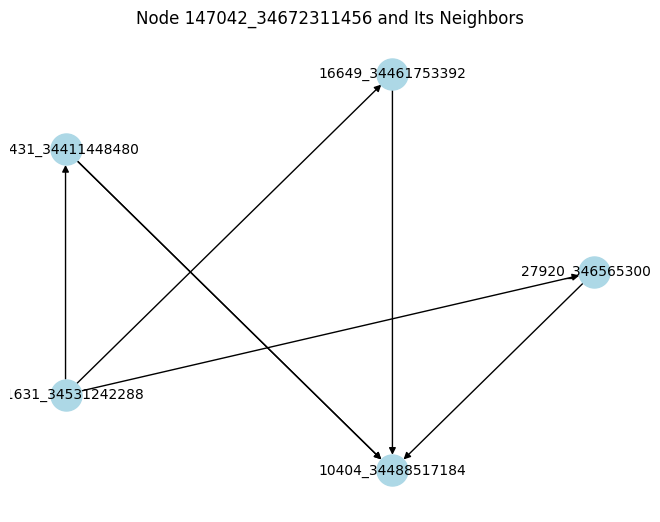

In [ ]:
# for key, value in Predected_Scenarios.items():
#     print(key, ':', len(value))

my_graph = Predected_Scenarios['SCATTER-GATHER'][12]
pos = nx.circular_layout(my_graph)  # Positions of nodes
nx.draw(my_graph, pos, with_labels=True, node_size=500, font_size=10, node_color='lightblue')
plt.title(f"Node {nodeA} and Its Neighbors")
plt.show()


In [ ]:
class_names = ['CYCLE', 'FAN-OUT', 'FAN-IN', 'STACK', 'GATHER-SCATTER', 'SCATTER-GATHER', 'RANDOM', 'BIPARTITE']


def get_prediction_and_confidence(model, data):
    model.eval()

    with torch.no_grad():
        logits = model(data.x, data.edge_index, data.batch)
        # print(logits)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1)
        confidence_score = torch.max(probabilities, dim=1).values


        predicted_class_indices = torch.argmax(logits, dim=1)
        predicted_class_names = [class_names[idx] for idx in predicted_class_indices]

    return predicted_class_names, confidence_score

label= 'SCATTER-GATHER'
extracted_graph= Predected_Scenarios[label][0]
predicted_class, confidence_score = get_prediction_and_confidence(model, convert_predected_to_data(extracted_graph ))
print(f" predicted class   {predicted_class}  and confidence score  {confidence_score} ")


 predicted class   ['FAN-IN']  and confidence score  tensor([0.9986]) 


In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import pairwise_kernels

In [ ]:
# from networkx.algorithms import graph_edit_distance

# # def confident_score_with_graph_metric(my_graph, label):

# #     sum=0
# #     for labeled_graph in scenarios_dict[label]:
# #         distance = graph_edit_distance(graph1, labeled_graph) # Calculate the Similarity Score
# #         # Calculate the similarity score
# #         max_distance = max(nx.number_of_nodes(my_graph), nx.number_of_nodes(labeled_graph))
# #         similarity_score = (max_distance - distance) / max_distance
# #         print(f"The similarity score between my_graph and Labeled_graph is: {similarity_score}")

# #         sum+= similarity_score
# #     final_confident_score= sum/ len(scenarios_dict[label])
# #     print(f" Confident score is {final_confident_score}")
# #     return(final_confident_score)

# def confident_score_with_graph_metric(my_graph, labeled_graph):

#         distance = graph_edit_distance(my_graph, labeled_graph) # Calculate the Similarity Score
#         # Calculate the similarity score
#         max_distance = max(nx.number_of_nodes(my_graph), nx.number_of_nodes(labeled_graph))
#         similarity_score = (max_distance - distance) / max_distance
#         print(f"The similarity score between my_graph and Labeled_graph is: {similarity_score}")

#         return(similarity_score)

# labeled_graph= scenarios_dict[label][15]
# print(f" number of nodes : {len(labeled_graph.nodes())}")
# # labeled_graph= nx.parse_edgelist(labeled_graph.split('\n'), nodetype=int)
# pos = nx.circular_layout(labeled_graph)  # Positions of nodes
# nx.draw(labeled_graph, pos, with_labels=True, node_size=500, font_size=10, node_color='lightblue')
# plt.title(f"Node {nodeA} and Its Neighbors")
# plt.show()
# conf_score= confident_score_with_graph_metric(extracted_graph , label )

In [ ]:
from scipy.optimize import linear_sum_assignment
from itertools import combinations

def get_subgraph_isomorphism_similarity(graph1, graph2):
    # Initialize a similarity score
    similarity_score = 0.0

    # Iterate through all possible subgraphs of graph1
    for n in range(1, len(graph1.nodes()) + 1):
        for subgraph1_nodes in combinations(graph1.nodes(), n):
            subgraph1 = graph1.subgraph(subgraph1_nodes)

            # Iterate through all possible subgraphs of graph2
            for m in range(1, len(graph2.nodes()) + 1):
                for subgraph2_nodes in combinations(graph2.nodes(), m):
                    subgraph2 = graph2.subgraph(subgraph2_nodes)

                    # Check if subgraph1 is isomorphic to subgraph2
                    if nx.is_isomorphic(subgraph1, subgraph2):
                        # Increase the similarity score when an isomorphic subgraph is found
                        similarity_score += 1.0

    # Normalize the similarity score based on graph sizes
    max_possible_similarity = min(len(graph1), len(graph2))
    similarity_score /= max_possible_similarity

    return similarity_score

sample_graph= scenarios_dict['SCATTER-GATHER'][3]
similarity_score = get_subgraph_isomorphism_similarity(extracted_graph,sample_graph )
print(f"Similarity score between G1 and G2: {similarity_score}")

print()
isomorphic = nx.is_isomorphic(extracted_graph, sample_graph)
if isomorphic:
    print("The graphs are isomorphic (similar in structure).")
else:
    print("The graphs are not isomorphic (different in structure).")

Similarity score between G1 and G2: 18.8

The graphs are not isomorphic (different in structure).
